# Notebook reviews the POS tags distributions

In [1]:
import re
import pandas as pd
import copy
import numpy as np
import evaluate
from docx import Document
class DataLoader:
    """
    Loader for benchmarking datasets to ensure universal formatting. To be used in conjunction with DyslexiaInjector.
    ...
    Attributes
    ----------
    path: str
        Path to csv, txt or docx file of the data. In the case of CSV there should only be 1 column
    data: list
        A list of striings
    dataset_name: str
        Name of the dataset that is used when saving the data
        
    Methods
    -------
    save_as_txt(path):
        Saves data as a text file to specified path
    save_as_csv(path):
        Saves data as a csv file to specified path
    get_data():
        Returns data
    create_deepcopy():
        Returns a deep copy of the class instance
    get_name():
        returns name of the dataset (dataset_name)
    
    Usage
    -------
    >>> from datasets import load_dataset
    >>> from DataLoader import DataLoader
    >>> dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
    >>> to_translate = []
    >>> for i in range(len(dataset_wmt_enfr)):
    >>>     to_translate.append(dataset_wmt_enfr[i]['translation']['en'])
    >>> loader = DataLoader(data=to_translate, dataset_name="wmt14_enfr")
    >>> loader.save_as_txt("wmt14_enfr.txt")
    We can also use the text file to create a new DataLoader instance
    >>> loader2 = DataLoader(path="wmt14_enfr.txt", dataset_name="wmt14_enfr")
    """
    # Constructor
    def __init__(self, path=None, data=None, dataset_name=""):
        self.dataset_name = dataset_name
        if data is None and path is not None:
            #check path to see if file is txt or csv
            file_type = path.split(".")[-1]
            if file_type == "txt":
                self.data = self.parse_txt(path)
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "csv":
                self.data = pd.read_csv(path, header=None)
                self.data = self.data[0].tolist()
                #fix any formatting issues
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "docx":
                doc = Document(path)
                self.data = [self.fix_format(paragraph.text) for paragraph in doc.paragraphs]
            else:
                raise Exception("Invalid file type")
        elif data is not None:
            #check if data is a list or a df
            if isinstance(data, list):
                #format each sentence in data
                self.data = [self.fix_format(sentence) for sentence in data]
            else:
                raise Exception("Invalid data type, please pass in a list of sentences")
        else:
            raise Exception("Please pass in a path or data")

    def parse_txt(self, path):
        output = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                output.append(self.fix_format(line))
        return output
                
    def fix_format(self, sentence):
        #remove spacing before punctuation
        sentence = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', sentence)
        #replace any double spaces with single space
        sentence = re.sub(r'\s+', ' ', sentence)
        #remove any leading or trailing spaces
        sentence = sentence.strip()
        #make all quotes (german and french) english double quotes
        sentence = re.sub(r'«|»|„|“', '"', sentence)
        #make all single quotes english single quotes
        sentence = re.sub(r'‘|’', "'", sentence)
        #make all french guillemets english double quotes
        sentence = re.sub(r'‹|›', '"', sentence)
        #if sentence begins and ends with quotes and there are only two, remove them
        if sentence[0] == '"' and sentence[-1] == '"' and sentence.count('"') == 2:
            sentence = sentence[1:-1]
        elif sentence[0] == "'" and sentence[-1] == "'" and sentence.count("'") == 2:
            sentence = sentence[1:-1]
        return sentence

    def save_as_txt(self, path):
        with open(path, "w", encoding="utf-8") as f:
            for sentence in self.data:
                f.write(f"{sentence}\n")
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_csv(self, path):
        df = pd.DataFrame(self.data)
        df.to_csv(path, index=False, header=False, encoding='utf-8')
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_docx(self, path):
        document = Document()
        for sentence in self.data:
            document.add_paragraph(sentence)
        document.save(path)
        print(f"Saved {self.dataset_name} to {path}")
        return

    def get_data(self):
        return self.data

    def create_deepcopy(self):
        return DataLoader(data=copy.deepcopy(self.data), dataset_name=self.dataset_name)
        
    def get_name(self):
        return self.dataset_name

    def get_number_of_sentences(self):
        return len(self.data)
    
    def get_number_of_words(self):
        return sum([len(sentence.split()) for sentence in self.data])
    
    def get_number_of_letters(self):
        #need to ensure we only count letters and not punctuation
        return sum([len(re.sub(r'[^\w\s]','',sentence)) for sentence in self.data])
    
    def get_bleue_score(self, reference):
        #returns bleu score of the data against a reference
        bleu = evaluate.load("bleu")
        if type(reference) == list:
            return bleu.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleu.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_wer(self, reference):
        #returns wer score of the data against a reference
        wer = evaluate.load("wer")
        if type(reference) == list:
            return wer.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return wer.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_bleurt_score(self, reference):
        #returns bleurt score of the data against a reference
        bleurt = evaluate.load("bleurt")
        if type(reference) == list:
            return bleurt.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleurt.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
    
    def get_bert_score(self, reference):
        #returns bert score of the data against a reference
        bert = evaluate.load("bertscore")
        if type(reference) == list:
            return bert.compute(predictions=self.data, references=reference, lang="fr")
        elif type(reference) == DataLoader:
            return bert.compute(predictions=self.data, references=reference.get_data(),  lang="fr")
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
            

c:\Users\gerge\anaconda3\envs\Dyslexia_Research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import spacy
import os

In [3]:
#need to loop through file directory
aws_data_v1 = []
aws_data_v2 = []
for filename in os.listdir("output_data/v1/aws"):
    temp = DataLoader(path="output_data/v1/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v1.append(temp)

for filename in os.listdir("output_data/v2/aws"):
    temp = DataLoader(path="output_data/v2/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v2.append(temp)

azure_data_v1 = []
for filename in os.listdir("output_data/v1/azure"):
    temp = DataLoader(path="output_data/v1/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v1.append(temp)

azure_data_v2 = []
for filename in os.listdir("output_data/v2/azure"):
    temp = DataLoader(path="output_data/v2/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v2.append(temp)

google_data_v1 = []
for filename in os.listdir("output_data/v1/google"):
    temp = DataLoader(path="output_data/v1/google/"+filename, dataset_name="google_"+filename)
    google_data_v1.append(temp)

google_data_v2 = []
for filename in os.listdir("output_data/v2/google"):
    temp = DataLoader(path="output_data/v2/google/"+filename, dataset_name="google_"+filename)
    google_data_v2.append(temp)

gpt_data_v1 = []
for filename in os.listdir("output_data/v1/gpt"):
    temp = DataLoader(path="output_data/v1/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v1.append(temp)

gpt_data_v2 = []
for filename in os.listdir("output_data/v2/gpt"):
    temp = DataLoader(path="output_data/v2/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v2.append(temp)

from datasets import load_dataset
dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
to_translate_wmt14_en = []
reference_wmt14_fr = []

for i in range(len(dataset_wmt_enfr)):
    to_translate_wmt14_en.append(dataset_wmt_enfr[i]['translation']['en'])
    reference_wmt14_fr.append(dataset_wmt_enfr[i]['translation']['fr'])

reference_corpus_fr = DataLoader(data=reference_wmt14_fr, dataset_name="wmt14_fr")
reference_corpus_en = DataLoader(data=to_translate_wmt14_en, dataset_name="wmt14_en")


Found cached dataset wmt14 (C:/Users/gerge/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


In [4]:
aws_bleu_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V1 scores: {aws_bleu_scores_v1}")

aws_bleu_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V2 scores: {aws_bleu_scores_v2}")

google_bleu_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V1 scores: {google_bleu_scores_v1}")

google_bleu_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V2 scores: {google_bleu_scores_v2}")

azure_bleu_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU scores: {azure_bleu_scores_v1}")

azure_bleu_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU V2 scores: {azure_bleu_scores_v2}")

gpt_bleu_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V1 scores: {gpt_bleu_scores_v1}")

gpt_bleu_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V2 scores: {gpt_bleu_scores_v2}")
#same of above but for WER
aws_wer_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V1 scores: {aws_wer_scores_v1}")

aws_wer_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V2 scores: {aws_wer_scores_v2}")

google_wer_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V1 scores: {google_wer_scores_v1}")

google_wer_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V2 scores: {google_wer_scores_v2}")

azure_wer_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER scores: {azure_wer_scores_v1}")

azure_wer_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER V2 scores: {azure_wer_scores_v2}")

gpt_wer_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V1 scores: {gpt_wer_scores_v1}")

gpt_wer_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V2 scores: {gpt_wer_scores_v2}")

# aws_bert_scores_v1 = []
# for data in aws_data_v1:
#     print(data.get_name())
#     aws_bert_scores_v1.append(data.get_bert_score(reference_corpus_fr))
# print(f"AWS BERT V1 scores: {aws_bert_scores_v1}")

# aws_bert_scores_v2 = []
# for data in aws_data_v2:
#     print(data.get_name())
#     aws_bert_scores_v2.append(data.get_bert_score(reference_corpus_fr))
# print(f"AWS BERT V2 scores: {aws_bert_scores_v2}")

# google_bert_scores_v1 = []
# for data in google_data_v1:
#     print(data.get_name())
#     google_bert_scores_v1.append(data.get_bert_score(reference_corpus_fr))
# print(f"Google BERT V1 scores: {google_bert_scores_v1}")

# google_bert_scores_v2 = []
# for data in google_data_v2:
#     print(data.get_name())
#     google_bert_scores_v2.append(data.get_bert_score(reference_corpus_fr))
# print(f"Google BERT V2 scores: {google_bert_scores_v2}")

# azure_bert_scores_v1 = []
# for data in azure_data_v1:
#     print(data.get_name())
#     azure_bert_scores_v1.append(data.get_bert_score(reference_corpus_fr))
# print(f"Azure BERT scores: {azure_bert_scores_v1}")

# azure_bert_scores_v2 = []
# for data in azure_data_v2:
#     print(data.get_name())
#     azure_bert_scores_v2.append(data.get_bert_score(reference_corpus_fr))
# print(f"Azure BERT V2 scores: {azure_bert_scores_v2}")

# gpt_bert_scores_v1 = []
# for data in gpt_data_v1:
#     print(data.get_name())
#     gpt_bert_scores_v1.append(data.get_bert_score(reference_corpus_fr))
# print(f"GPT BERT V1 scores: {gpt_bert_scores_v1}")

# gpt_bert_scores_v2 = []
# for data in gpt_data_v2:
#     print(data.get_name())
#     gpt_bert_scores_v2.append(data.get_bert_score(reference_corpus_fr))
# print(f"GPT BERT V2 scores: {gpt_bert_scores_v2}")



aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.1.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.1_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.2_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.1_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.2_p_letter_0.0_p_confusing_word_0.0.txt
AWS BLEU V1 scores: [{'bleu': 0.4561216039012071, 'precisions': [0.7113003696141021, 0.5157512605042017, 0.3915541108557978, 0.3013265858331749], 'brevity_penalty': 1.0, 'length_ratio': 1.0010090556274256, 'translation_length': 77378, 'reference_length': 77300}, {'bleu': 0.4228095535642235, 'precisions': [0.6854196746866336, 0.4826468243422801, 0.35838742267185186, 0.26955065265103384], 'brevity_penalty': 1.0, 'length_ratio': 1.012457956015524, 'translation_length': 78263, 'reference_length': 77300}, {'bl

In [5]:

reference_corpus_fr.get_number_of_words()

69569

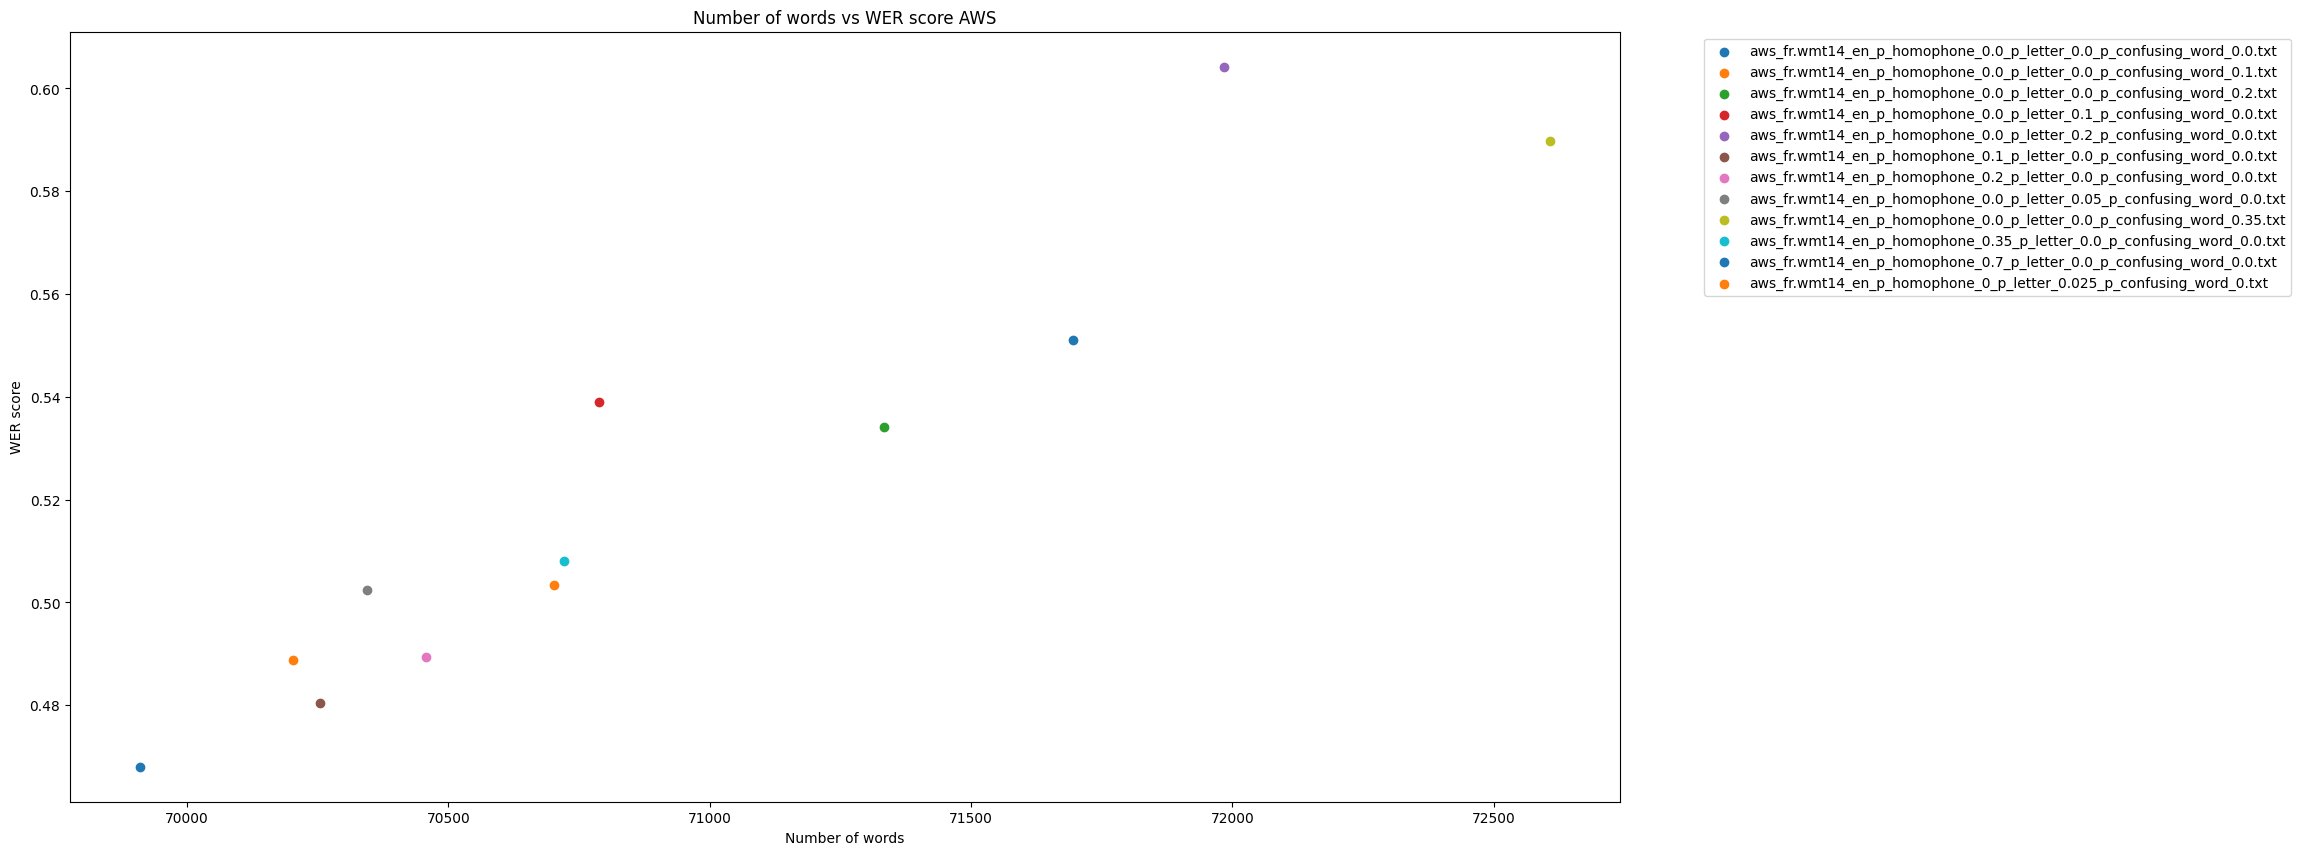

<Figure size 640x480 with 0 Axes>

In [6]:
#lets plot the number of words for each dataset in aws_data_v1

data_to_plot = {}
for i in range(len(aws_data_v1)):
    data_to_plot[aws_data_v1[i].get_name()] = (aws_data_v1[i].get_number_of_words(), aws_wer_scores_v1[i])

for i in range(len(aws_data_v2)):
    data_to_plot[aws_data_v2[i].get_name()] = (aws_data_v2[i].get_number_of_words(), aws_wer_scores_v2[i])
x_data = [data_to_plot[key][0] for key in data_to_plot.keys()]
y_data = [data_to_plot[key][1] for key in data_to_plot.keys()]
labels = [key for key in data_to_plot.keys()]


plt.figure(figsize=(20,10))
#make a scatter plot, x axis is the number of words, y axis is the WER score, we want different colour for each label, use ax to set the labels
for i in range(len(x_data)):
    plt.scatter(x_data[i], y_data[i], label=labels[i])

plt.xlabel("Number of words")
plt.ylabel("WER score")
plt.title("Number of words vs WER score AWS")
#make legend top left
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#save image
plt.savefig("graphs/aws_wer_vs_words.png")


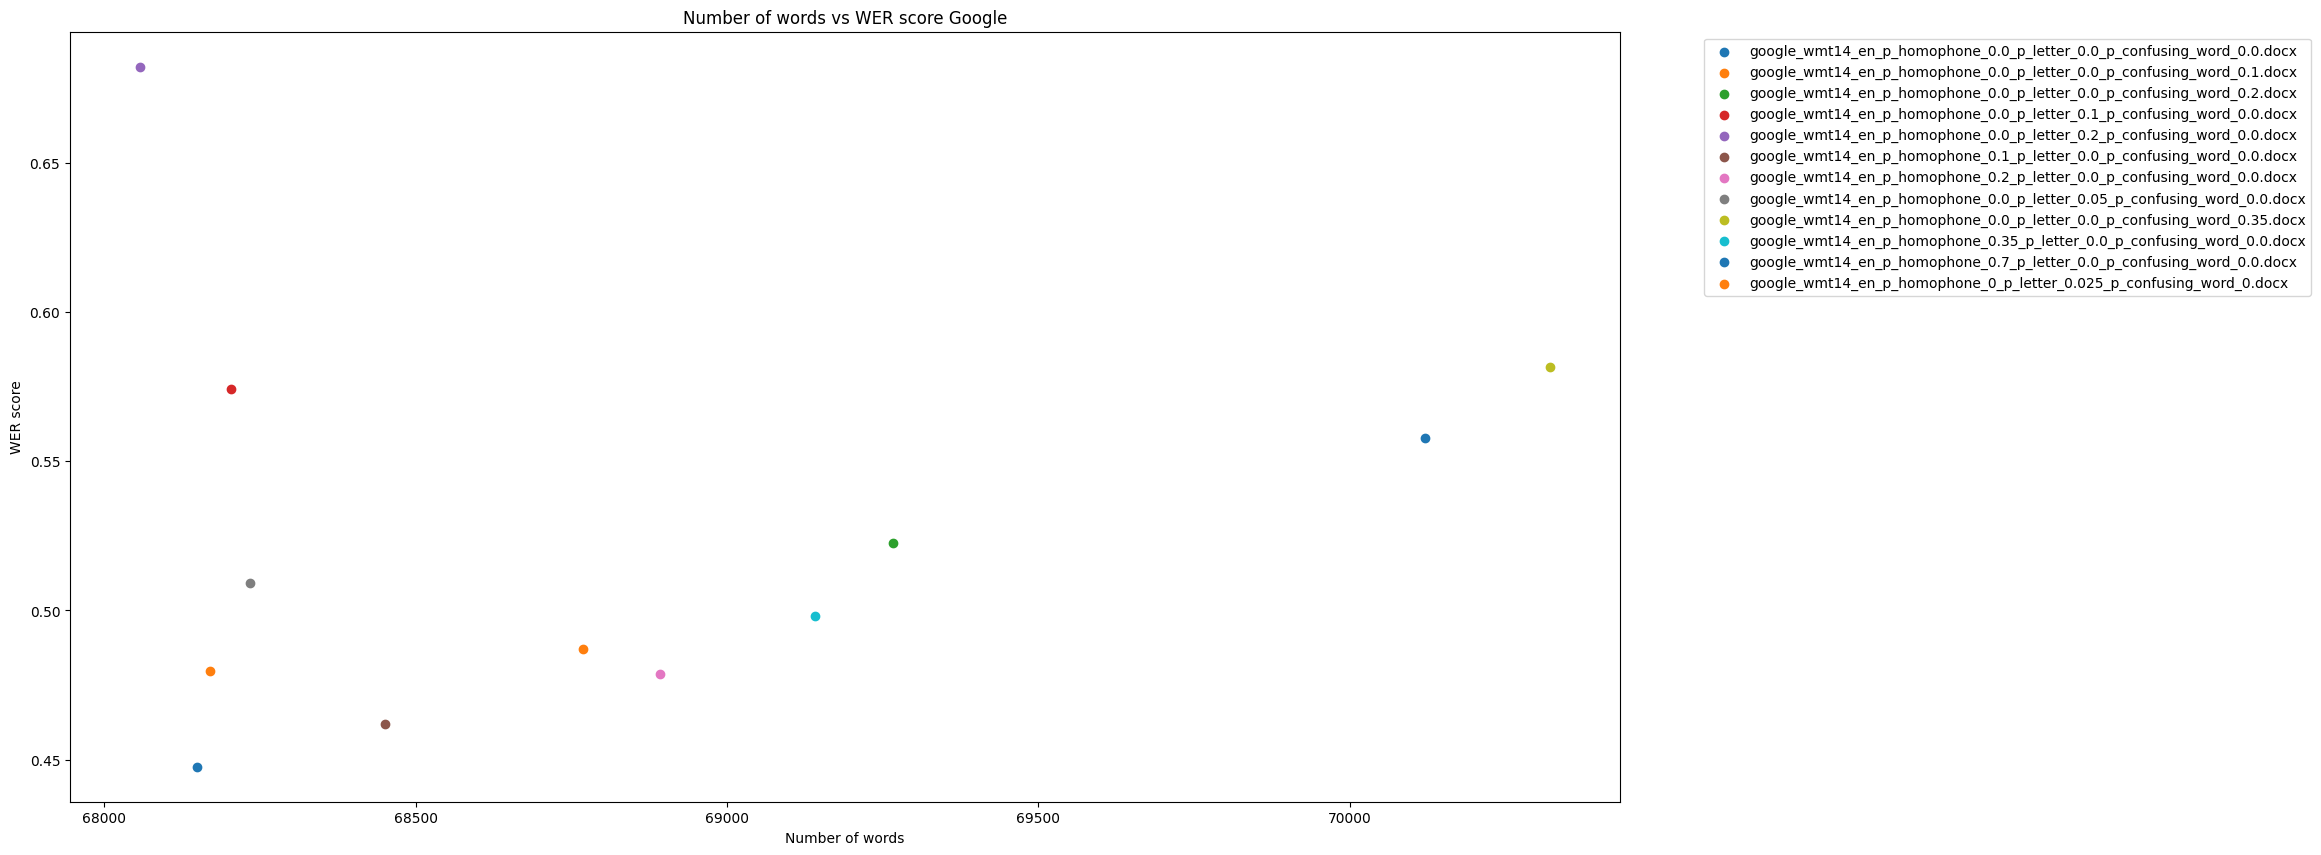

<Figure size 640x480 with 0 Axes>

In [7]:
data_to_plot = {}
for i in range(len(google_data_v1)):
    data_to_plot[google_data_v1[i].get_name()] = (google_data_v1[i].get_number_of_words(), google_wer_scores_v1[i])

for i in range(len(google_data_v2)):
    data_to_plot[google_data_v2[i].get_name()] = (google_data_v2[i].get_number_of_words(), google_wer_scores_v2[i])
x_data = [data_to_plot[key][0] for key in data_to_plot.keys()]
y_data = [data_to_plot[key][1] for key in data_to_plot.keys()]
labels = [key for key in data_to_plot.keys()]


data_to_plot["Baseline"] = reference_corpus_fr.get_number_of_words()

plt.figure(figsize=(20,10))
#make a scatter plot, x axis is the number of words, y axis is the WER score, we want different colour for each label, use ax to set the labels
for i in range(len(x_data)):
    plt.scatter(x_data[i], y_data[i], label=labels[i])

plt.xlabel("Number of words")
plt.ylabel("WER score")
plt.title("Number of words vs WER score Google")
#make legend top left
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
#save image
plt.savefig("graphs/google_wer_vs_words.png")

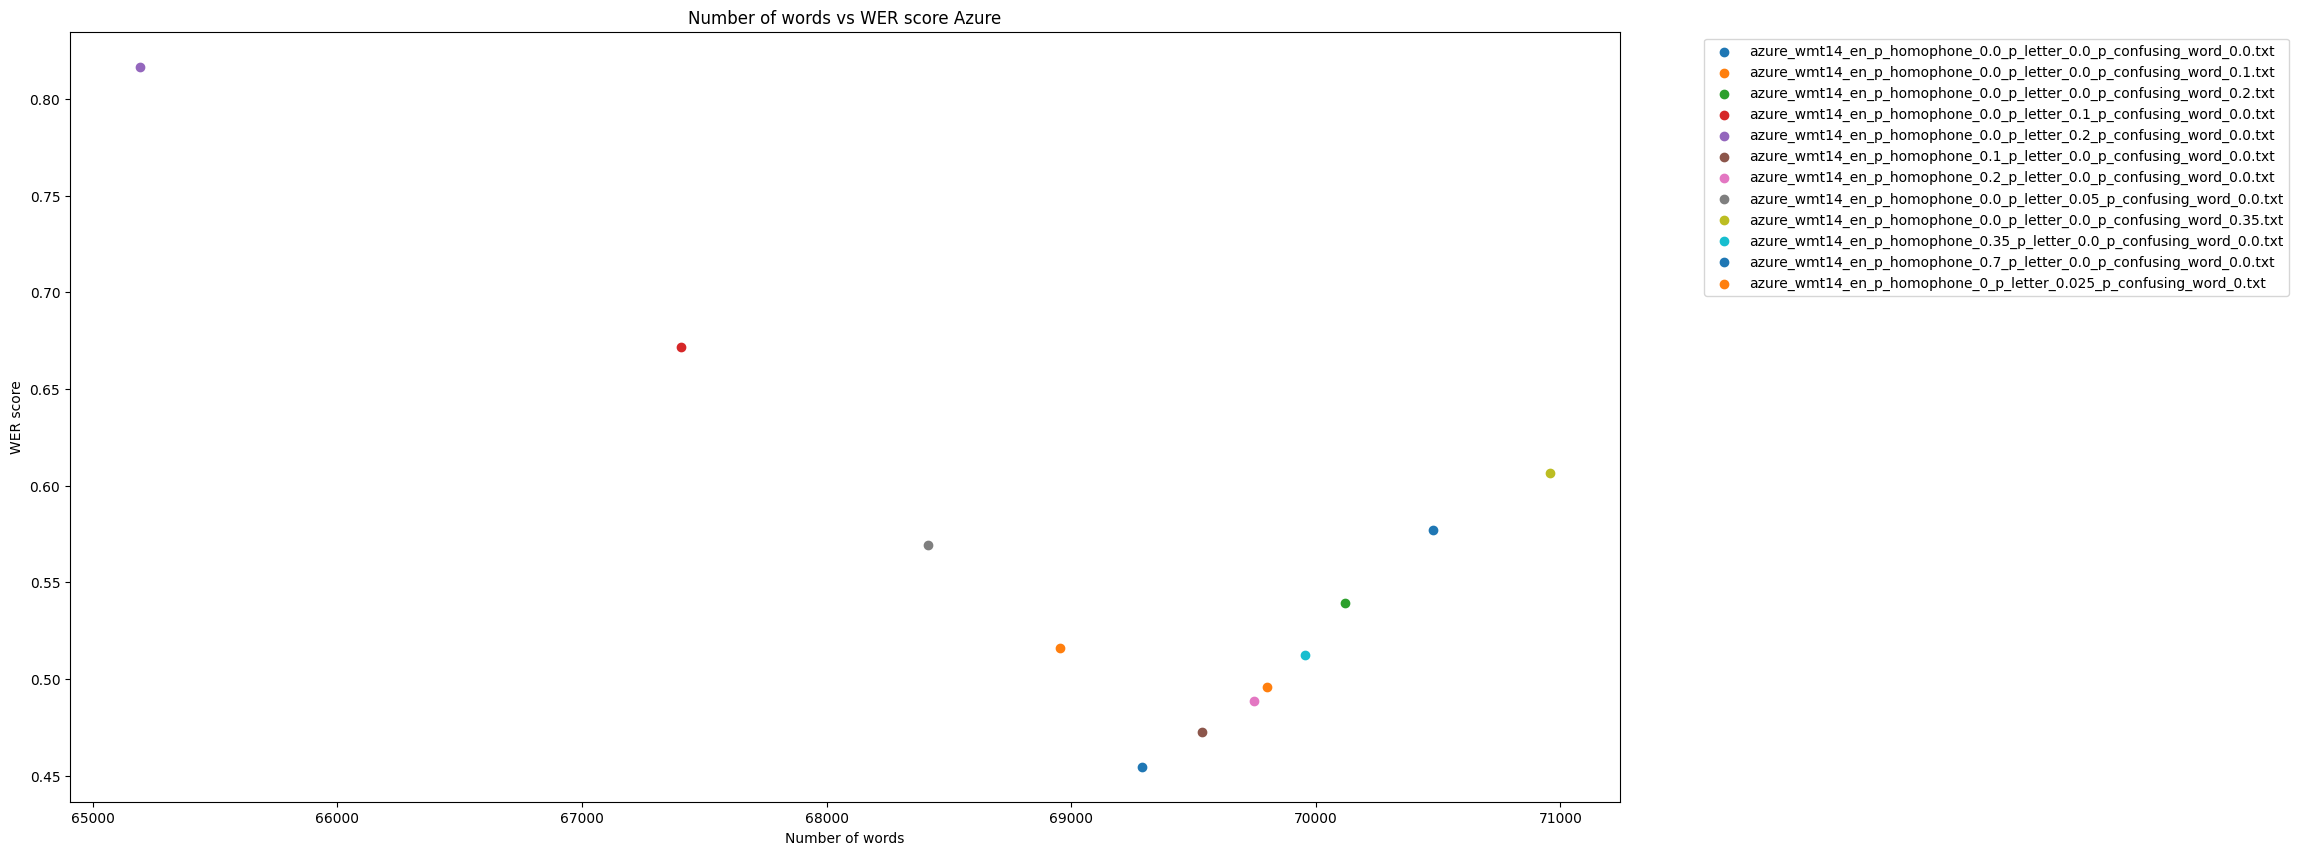

<Figure size 640x480 with 0 Axes>

In [8]:
data_to_plot = {}
for i in range(len(azure_data_v1)):
    data_to_plot[azure_data_v1[i].get_name()] = (azure_data_v1[i].get_number_of_words(), azure_wer_scores_v1[i])

for i in range(len(azure_data_v2)):
    data_to_plot[azure_data_v2[i].get_name()] = (azure_data_v2[i].get_number_of_words(), azure_wer_scores_v2[i])
x_data = [data_to_plot[key][0] for key in data_to_plot.keys()]
y_data = [data_to_plot[key][1] for key in data_to_plot.keys()]
labels = [key for key in data_to_plot.keys()]


data_to_plot["Baseline"] = reference_corpus_fr.get_number_of_words()

plt.figure(figsize=(20,10))
#make a scatter plot, x axis is the number of words, y axis is the WER score, we want different colour for each label, use ax to set the labels
for i in range(len(x_data)):
    plt.scatter(x_data[i], y_data[i], label=labels[i])

plt.xlabel("Number of words")
plt.ylabel("WER score")
plt.title("Number of words vs WER score Azure")
#make legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
#save image
plt.savefig("graphs/azure_wer_vs_words.png")


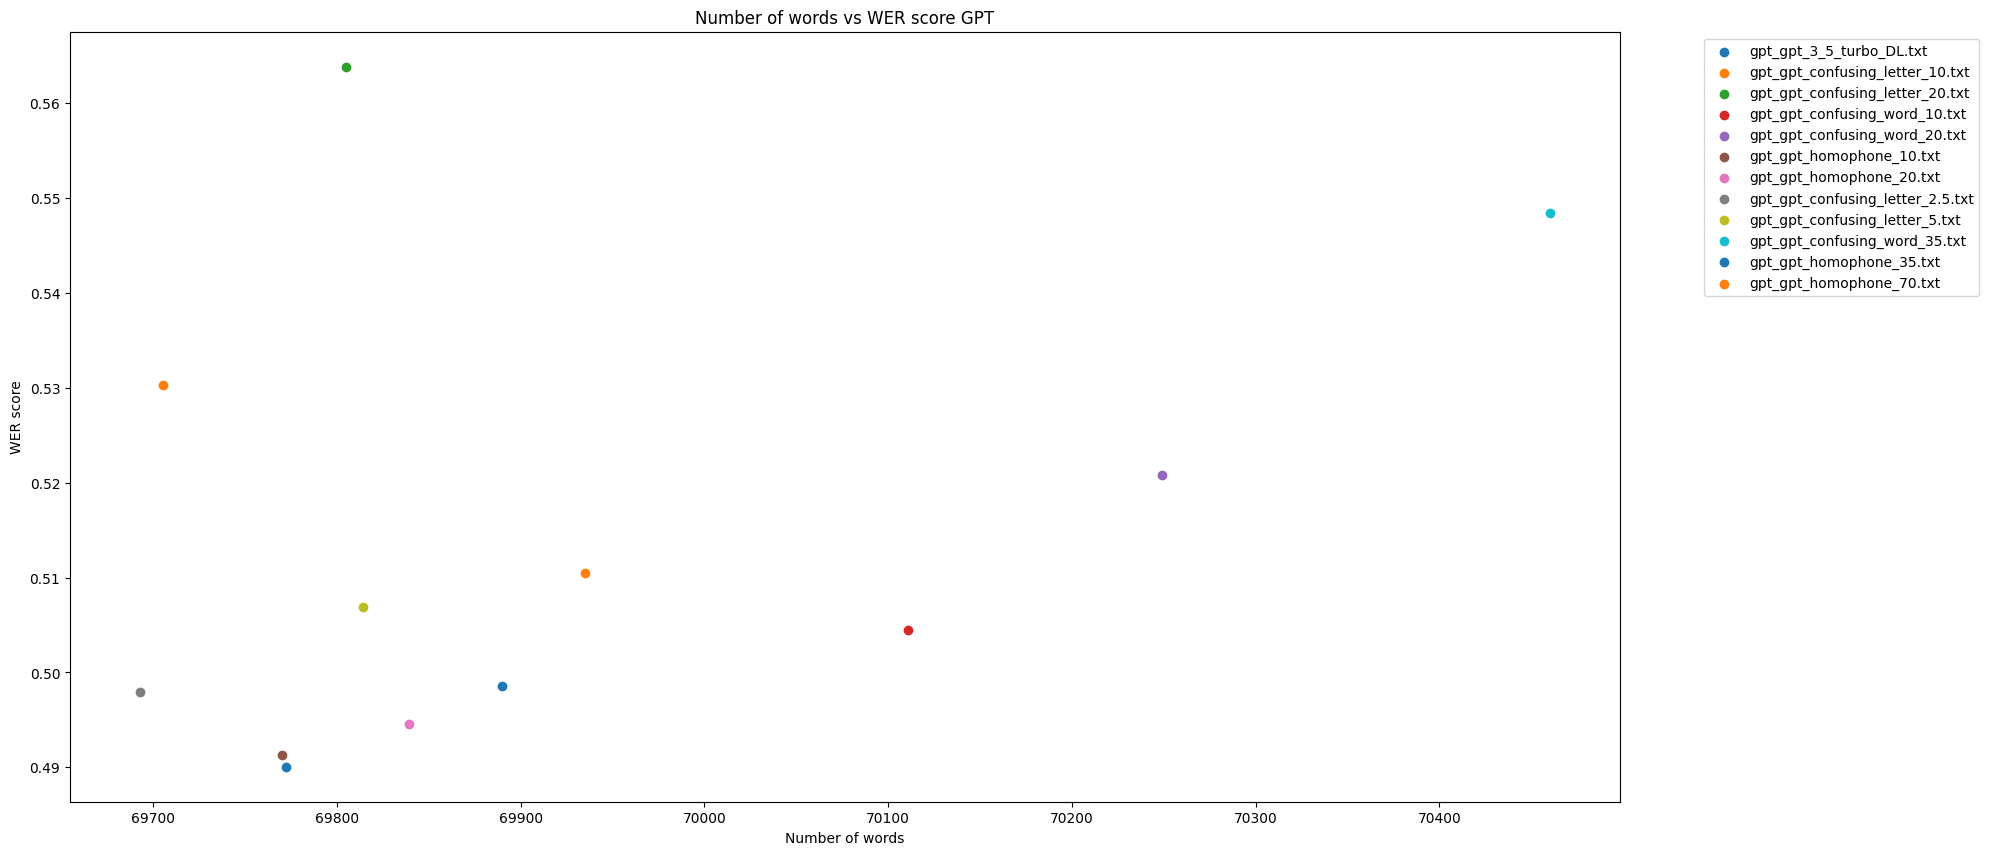

<Figure size 640x480 with 0 Axes>

In [9]:
data_to_plot = {}
for i in range(len(gpt_data_v1)):
    data_to_plot[gpt_data_v1[i].get_name()] = (gpt_data_v1[i].get_number_of_words(), gpt_wer_scores_v1[i])

for i in range(len(gpt_data_v2)):
    data_to_plot[gpt_data_v2[i].get_name()] = (gpt_data_v2[i].get_number_of_words(), gpt_wer_scores_v2[i])
x_data = [data_to_plot[key][0] for key in data_to_plot.keys()]
y_data = [data_to_plot[key][1] for key in data_to_plot.keys()]
labels = [key for key in data_to_plot.keys()]


data_to_plot["Baseline"] = reference_corpus_fr.get_number_of_words()

plt.figure(figsize=(20,10))
#make a scatter plot, x axis is the number of words, y axis is the WER score, we want different colour for each label, use ax to set the labels
for i in range(len(x_data)):
    plt.scatter(x_data[i], y_data[i], label=labels[i])

plt.xlabel("Number of words")
plt.ylabel("WER score")
plt.title("Number of words vs WER score GPT")
#make legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
#save image
plt.savefig("graphs/gpt_wer_vs_words.png")


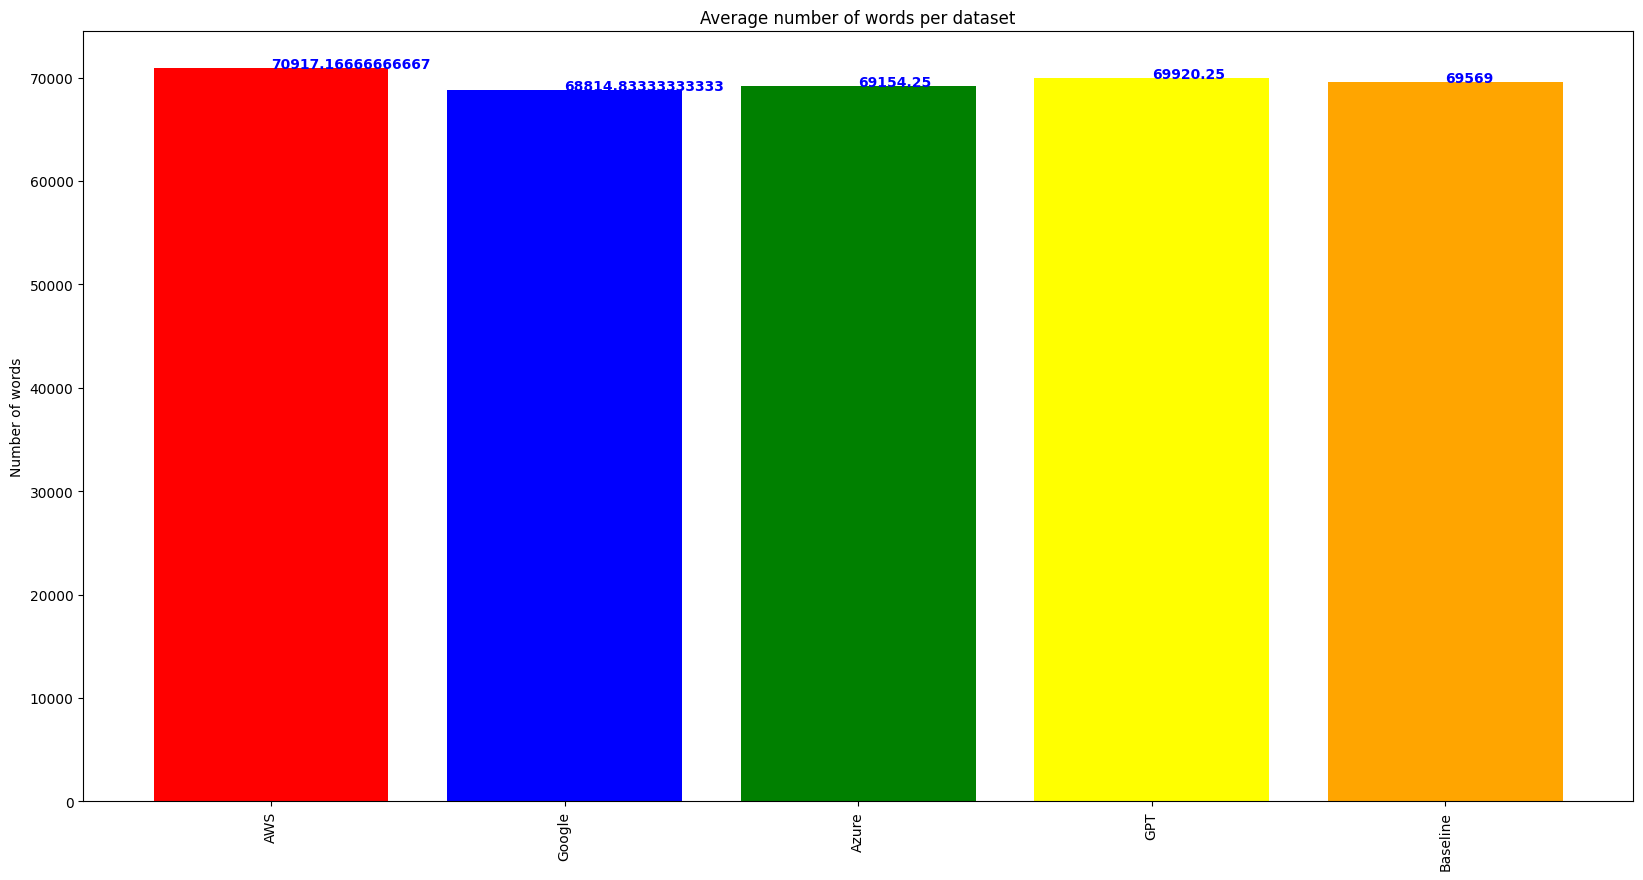

In [10]:
#lets get the average amount of words per service and plot it
aws_avg_nbr_words = (sum([data.get_number_of_words() for data in aws_data_v1])+sum([data.get_number_of_words() for data in aws_data_v2])) / (len(aws_data_v1)+len(aws_data_v2))
google_avg_nbr_words = (sum([data.get_number_of_words() for data in google_data_v1])+sum([data.get_number_of_words() for data in google_data_v2]) )/ (len(google_data_v1)+len(google_data_v2))
azure_avg_nbr_words = (sum([data.get_number_of_words() for data in azure_data_v1])+sum([data.get_number_of_words() for data in azure_data_v2]) )/ (len(azure_data_v1)+len(azure_data_v2))
gpt_avg_nbr_words = (sum([data.get_number_of_words() for data in gpt_data_v1])+sum([data.get_number_of_words() for data in gpt_data_v2]) )/ (len(gpt_data_v1)+len(gpt_data_v2))

data_to_plot = {"AWS":aws_avg_nbr_words, "Google":google_avg_nbr_words, "Azure":azure_avg_nbr_words, "GPT":gpt_avg_nbr_words, "Baseline":reference_corpus_fr.get_number_of_words()}
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of words")
plt.title("Average number of words per dataset")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
#make each bar a different colour
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center', color=['red', 'blue', 'green', 'yellow', 'orange'])
plt.show()


In [11]:
#load spacy french model
nlp = spacy.load("fr_core_news_sm")

In [12]:
#lets get the term frequency in baseline
baseline_term_freq = {}
for sentence in reference_corpus_fr.get_data():
    doc = nlp(sentence)
    for token in doc:
        #skip any punctuation
        if token.is_punct:
            continue
        if token.text not in baseline_term_freq:
            baseline_term_freq[token.text] = 1
        else:
            baseline_term_freq[token.text] += 1


In [13]:
doc = nlp("Voici une phrase qui n'est pas très longue")
for token in doc:
    print(token.pos_)

VERB
DET
NOUN
PRON
ADV
AUX
ADV
ADV
ADJ


In [14]:
def get_tags(data):
    #returns a dictionary of tags and their frequency
    tags = {}
    for sentence in data.get_data():
        doc = nlp(sentence)
        for token in doc:
            if token.pos_ not in tags:
                tags[token.pos_] = 1
            else:
                tags[token.pos_] += 1
    return tags

In [15]:
baseline_tags = []
for sentence in reference_corpus_fr.get_data():
    doc = nlp(sentence)
    to_add = []
    for token in doc:
        to_add.append(token.pos_)
    baseline_tags.append(to_add)
amazon_baseline_tags = []
for sentence in aws_data_v1[0].get_data():
    doc = nlp(sentence)
    to_add = []
    for token in doc:
        to_add.append(token.pos_)
    amazon_baseline_tags.append(to_add)
google_baseline_tags = []
for sentence in google_data_v1[0].get_data():
    doc = nlp(sentence)
    to_add = []
    for token in doc:
        to_add.append(token.pos_)
    google_baseline_tags.append(to_add)
azure_baseline_tags = []
for sentence in azure_data_v1[0].get_data():
    doc = nlp(sentence)
    to_add = []
    for token in doc:
        to_add.append(token.pos_)
    azure_baseline_tags.append(to_add)
gpt_baseline_tags = []
for sentence in gpt_data_v1[0].get_data():
    doc = nlp(sentence)
    to_add = []
    for token in doc:
        to_add.append(token.pos_)
    gpt_baseline_tags.append(to_add)

In [16]:
# baseline_tags_dict = {}
# for sentence in baseline_tags:
#     for tag in sentence:
#         if tag not in baseline_tags_dict:
#             baseline_tags_dict[tag] = 1
#         else:
#             baseline_tags_dict[tag] += 1
baseline_tags_dict = get_tags(reference_corpus_fr)
amazon_baseline_tags_dict = get_tags(aws_data_v1[0])
google_baseline_tags_dict = get_tags(google_data_v1[0])
azure_baseline_tags_dict = get_tags(azure_data_v1[0])
gpt_baseline_tags_dict = get_tags(gpt_data_v1[0])



In [17]:
#lets get the datasets for 20% word change and 10% word change

confusing_word_10 = [get_tags(aws_data_v1[4]), get_tags(google_data_v1[4]), get_tags(azure_data_v1[4]), get_tags(gpt_data_v1[2])]
confusing_word_20 = [get_tags(aws_data_v2[1]), get_tags(google_data_v2[1]), get_tags(azure_data_v2[1]), get_tags(gpt_data_v2[2])]


confusing_letter_10 = [get_tags(aws_data_v2[4]), get_tags(google_data_v2[4]), get_tags(azure_data_v2[4]), get_tags(gpt_data_v2[0])]
confusing_letter_20 = [get_tags(aws_data_v2[0]), get_tags(google_data_v2[0]), get_tags(azure_data_v2[0]), get_tags(gpt_data_v2[1])]

homophone_10 = [get_tags(aws_data_v2[2]), get_tags(google_data_v2[2]), get_tags(azure_data_v2[2]), get_tags(gpt_data_v2[3])]
homophone_20 = [get_tags(aws_data_v2[3]), get_tags(google_data_v2[3]), get_tags(azure_data_v2[3]), get_tags(gpt_data_v2[4])]


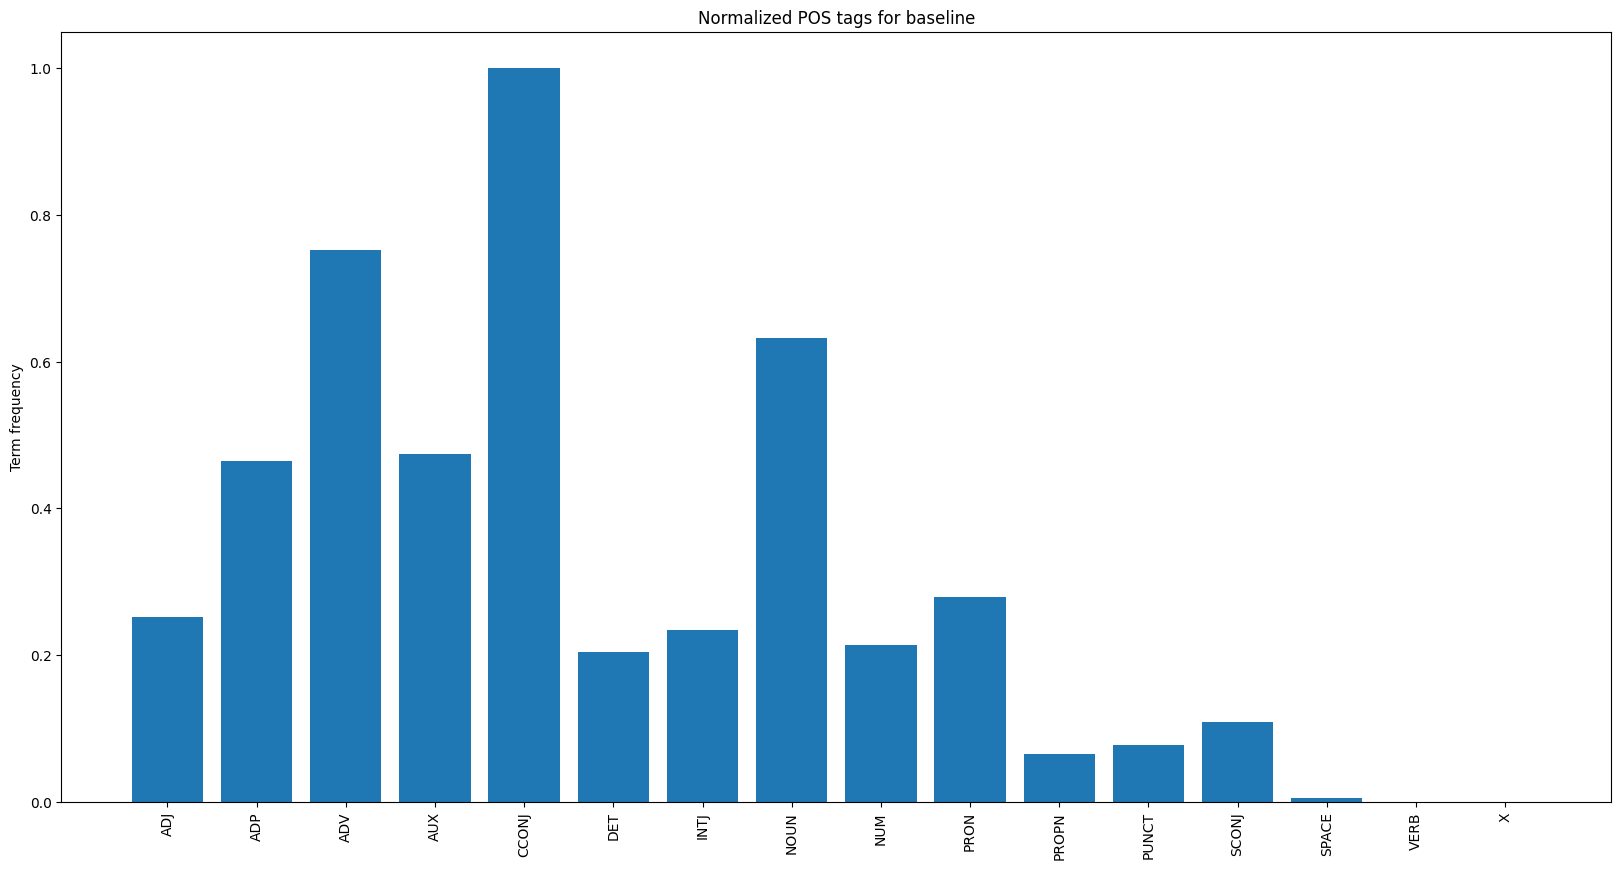

In [18]:
#lets plot the pos tags for the baseline_tags_dict
data_to_plot = baseline_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Term frequency")
plt.title("Normalized POS tags for baseline")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()


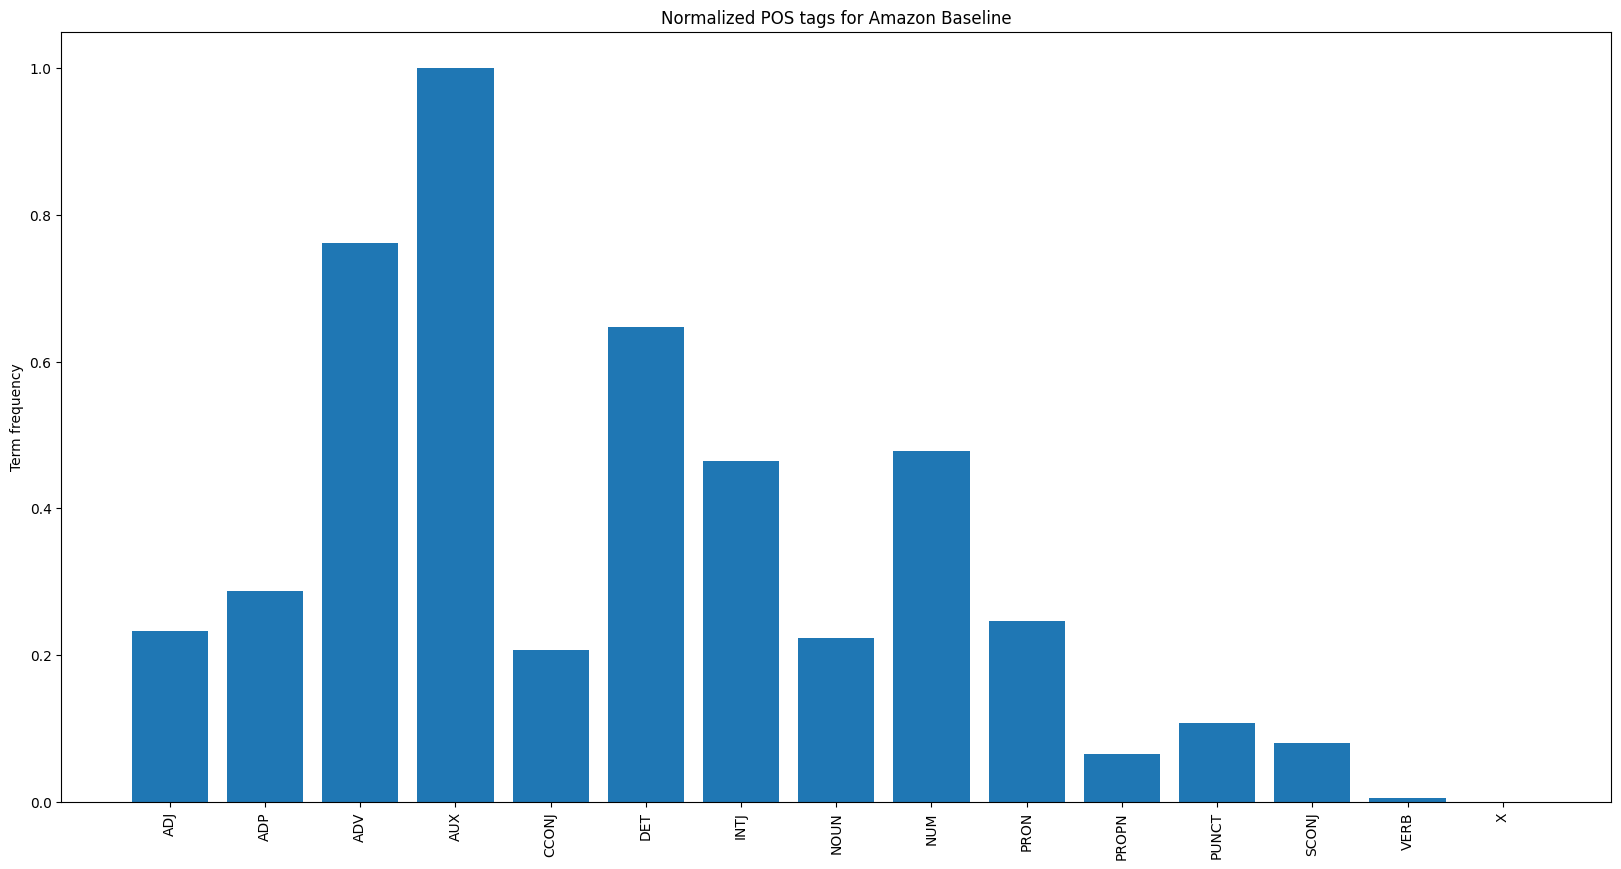

In [19]:
data_to_plot = amazon_baseline_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Term frequency")
plt.title("Normalized POS tags for Amazon Baseline")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()


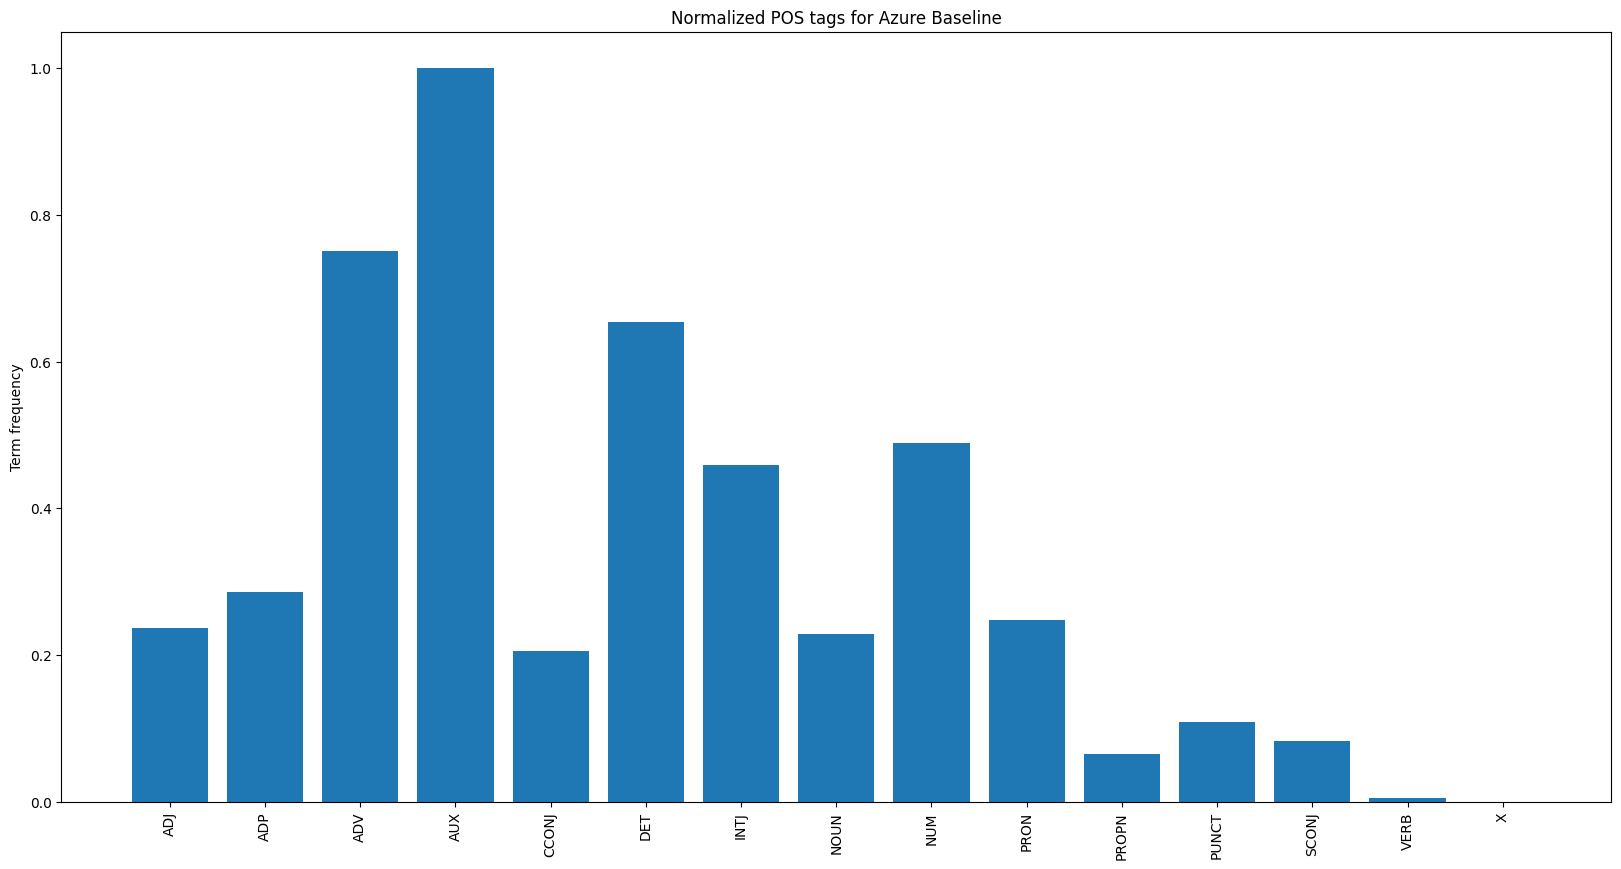

In [20]:
data_to_plot = azure_baseline_tags_dict 
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Term frequency")
plt.title("Normalized POS tags for Azure Baseline")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()


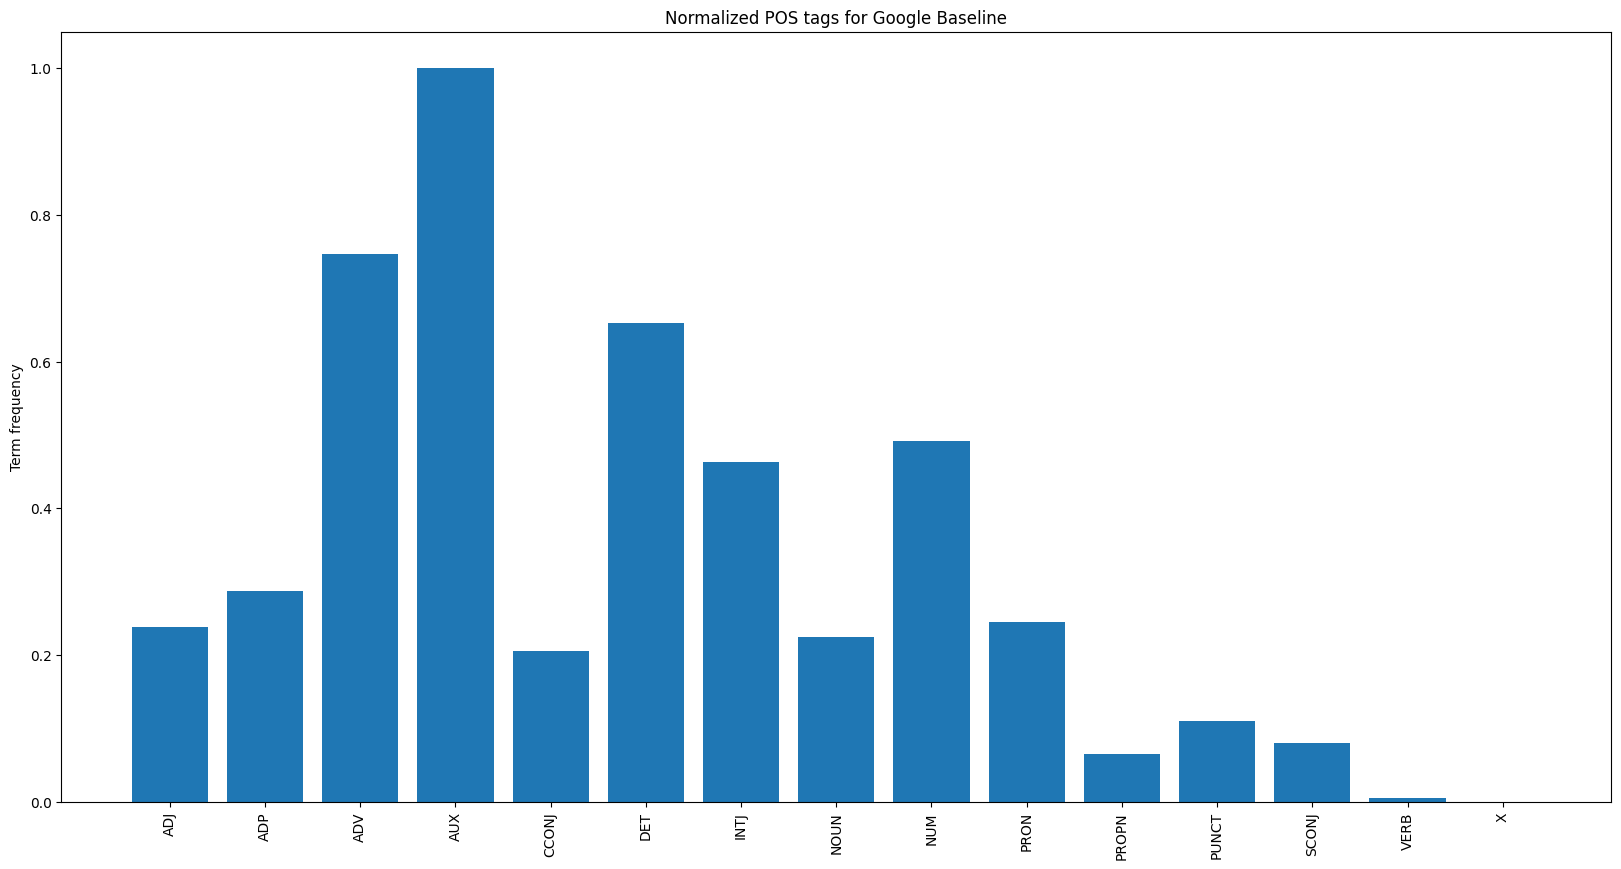

In [21]:
data_to_plot = google_baseline_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Term frequency")
plt.title("Normalized POS tags for Google Baseline")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()


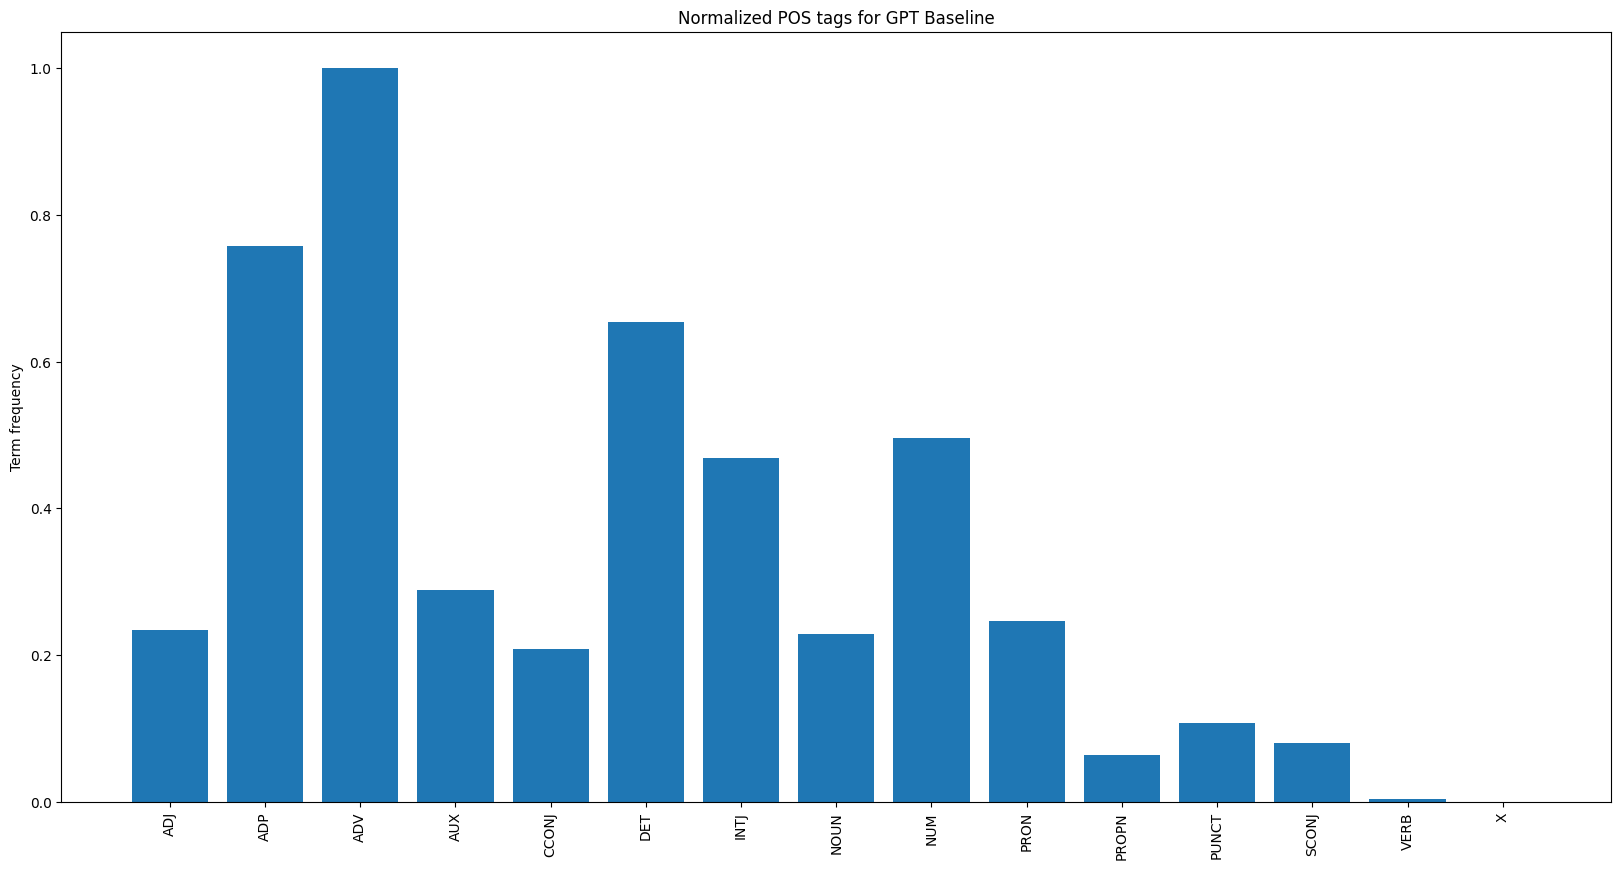

In [22]:
data_to_plot = gpt_baseline_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Term frequency")
plt.title("Normalized POS tags for GPT Baseline")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()


In [23]:
def diff_tags_dicts(baseline, other):
    #baseline is a dict of tags and their frequencies
    #other is a dict of tags and their frequencies
    #returns a dict of tags and their difference in frequency
    output = {}
    for key in baseline.keys():
        if key not in other:
            output[key] = baseline[key]
        else:
            output[key] = baseline[key] - other[key]
    return output

In [24]:
missing_amazon_tags_dict = diff_tags_dicts(baseline_tags_dict, amazon_baseline_tags_dict)
missing_google_tags_dict = diff_tags_dicts(baseline_tags_dict, google_baseline_tags_dict)
missing_azure_tags_dict = diff_tags_dicts(baseline_tags_dict, azure_baseline_tags_dict)
missing_gpt_tags_dict = diff_tags_dicts(baseline_tags_dict, gpt_baseline_tags_dict)

#same for 10% word change
missing_amazon_tags_dict_10_confusing_word = diff_tags_dicts(baseline_tags_dict, confusing_word_10[0])
missing_google_tags_dict_10_confusing_word = diff_tags_dicts(baseline_tags_dict, confusing_word_10[1])
missing_azure_tags_dict_10_confusing_word = diff_tags_dicts(baseline_tags_dict, confusing_word_10[2])
missing_gpt_tags_dict_10_confusing_word = diff_tags_dicts(baseline_tags_dict, confusing_word_10[3])

#same for 20% word change
missing_amazon_tags_dict_20_confusing_word = diff_tags_dicts(baseline_tags_dict, confusing_word_20[0])
missing_google_tags_dict_20_confusing_word = diff_tags_dicts(baseline_tags_dict, confusing_word_20[1])
missing_azure_tags_dict_20_confusing_word = diff_tags_dicts(baseline_tags_dict, confusing_word_20[2])
missing_gpt_tags_dict_20_confusing_word = diff_tags_dicts(baseline_tags_dict, confusing_word_20[3])

#10% letter change
missing_amazon_tags_dict_10_letter = diff_tags_dicts(baseline_tags_dict, confusing_letter_10[0])
missing_google_tags_dict_10_letter = diff_tags_dicts(baseline_tags_dict, confusing_letter_10[1])
missing_azure_tags_dict_10_letter = diff_tags_dicts(baseline_tags_dict, confusing_letter_10[2])
missing_gpt_tags_dict_10_letter = diff_tags_dicts(baseline_tags_dict, confusing_letter_10[3])

#20% letter change
missing_amazon_tags_dict_20_letter = diff_tags_dicts(baseline_tags_dict, confusing_letter_20[0])
missing_google_tags_dict_20_letter = diff_tags_dicts(baseline_tags_dict, confusing_letter_20[1])
missing_azure_tags_dict_20_letter = diff_tags_dicts(baseline_tags_dict, confusing_letter_20[2])
missing_gpt_tags_dict_20_letter = diff_tags_dicts(baseline_tags_dict, confusing_letter_20[3])

#10% homophone
missing_amazon_tags_dict_10_homophone = diff_tags_dicts(baseline_tags_dict, homophone_10[0])
missing_google_tags_dict_10_homophone = diff_tags_dicts(baseline_tags_dict, homophone_10[1])
missing_azure_tags_dict_10_homophone = diff_tags_dicts(baseline_tags_dict, homophone_10[2])
missing_gpt_tags_dict_10_homophone = diff_tags_dicts(baseline_tags_dict, homophone_10[3])

#20% homophone
missing_amazon_tags_dict_20_homophone = diff_tags_dicts(baseline_tags_dict, homophone_20[0])
missing_google_tags_dict_20_homophone = diff_tags_dicts(baseline_tags_dict, homophone_20[1])
missing_azure_tags_dict_20_homophone = diff_tags_dicts(baseline_tags_dict, homophone_20[2])
missing_gpt_tags_dict_20_homophone = diff_tags_dicts(baseline_tags_dict, homophone_20[3])




In [71]:
from sklearn.preprocessing import MinMaxScaler

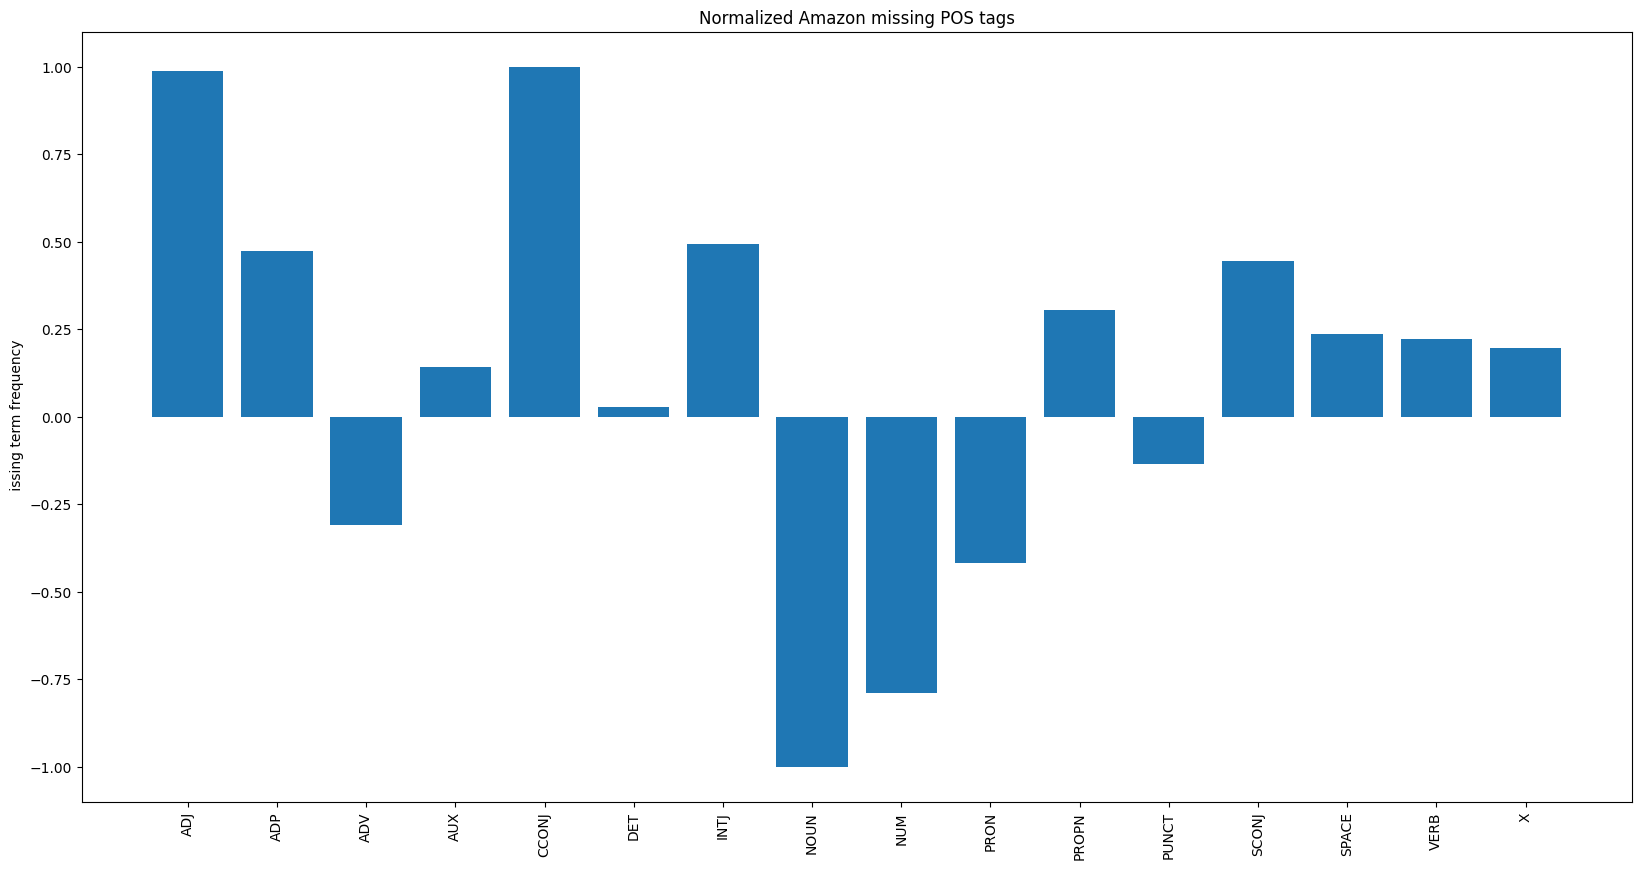

In [74]:
data_to_plot = missing_amazon_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1 lowest negative values become 0
y_data = list(data_to_plot.values())
#add abs value of lowest negative value to all values
#y_data = [y + abs(min(y_data)) for y in y_data]
normalizer = MinMaxScaler(feature_range=(-1, 1))
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
#y_data = [y / max(y_data) for y in y_data]
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel(" issing term frequency")
plt.title("Normalized Amazon missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
#plt.text(0, -250, "Negative values mean that the tag is more frequent in Amazon than baseline", fontsize=10)
plt.show()


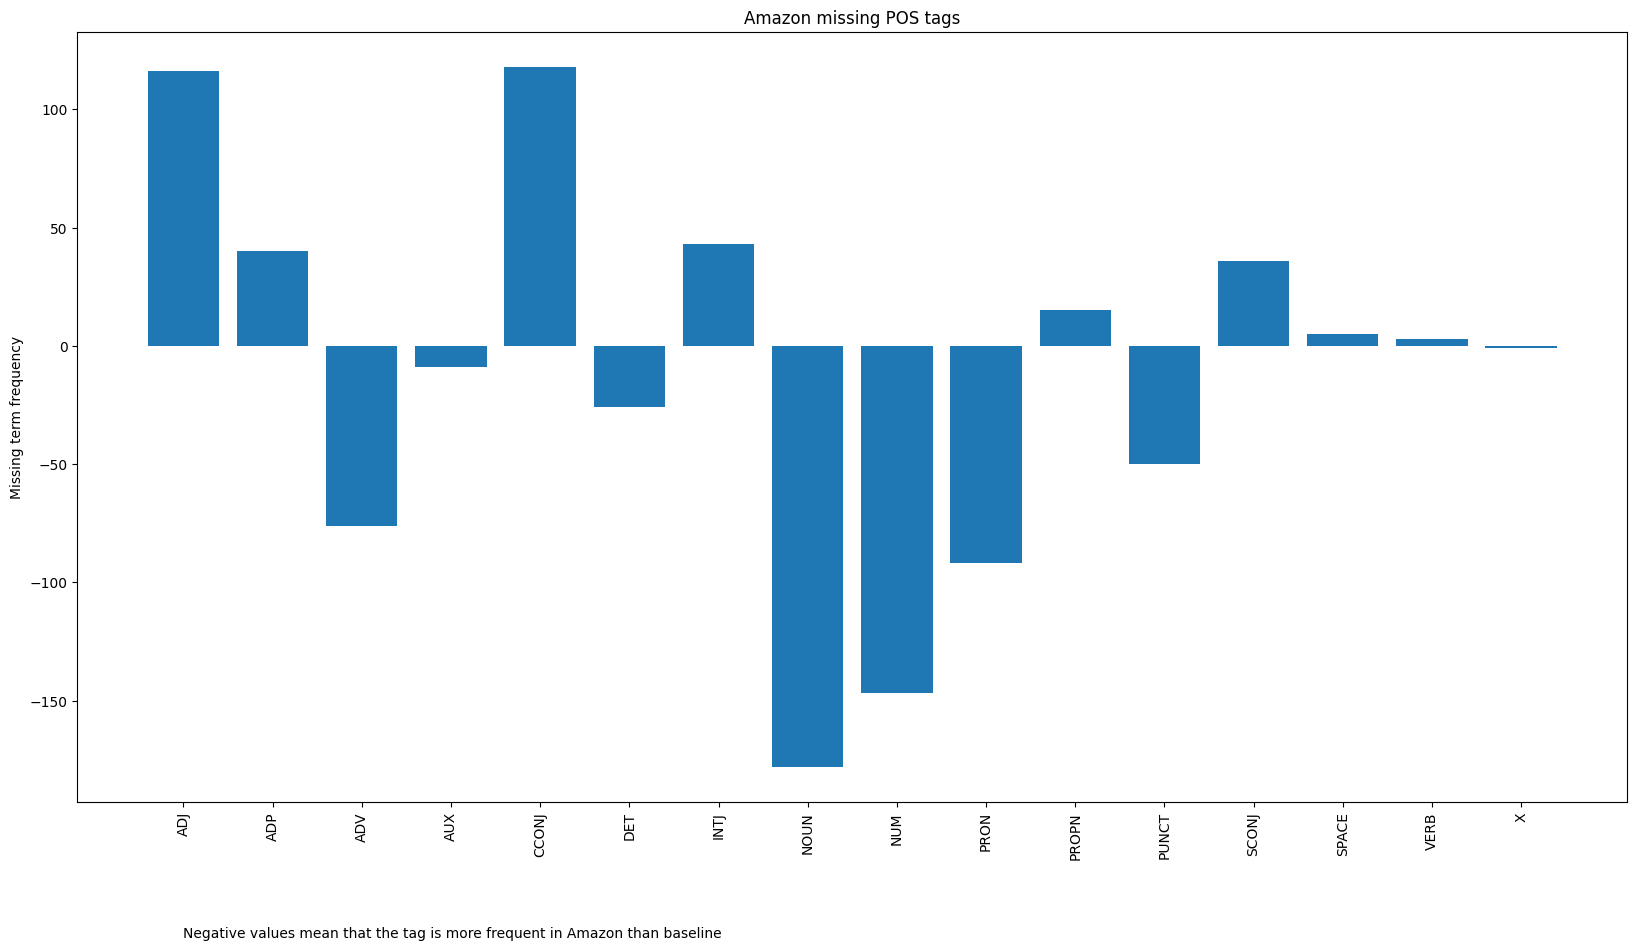

In [64]:
data_to_plot = missing_amazon_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Amazon missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.text(0, -250, "Negative values mean that the tag is more frequent in Amazon than baseline", fontsize=10)
plt.show()


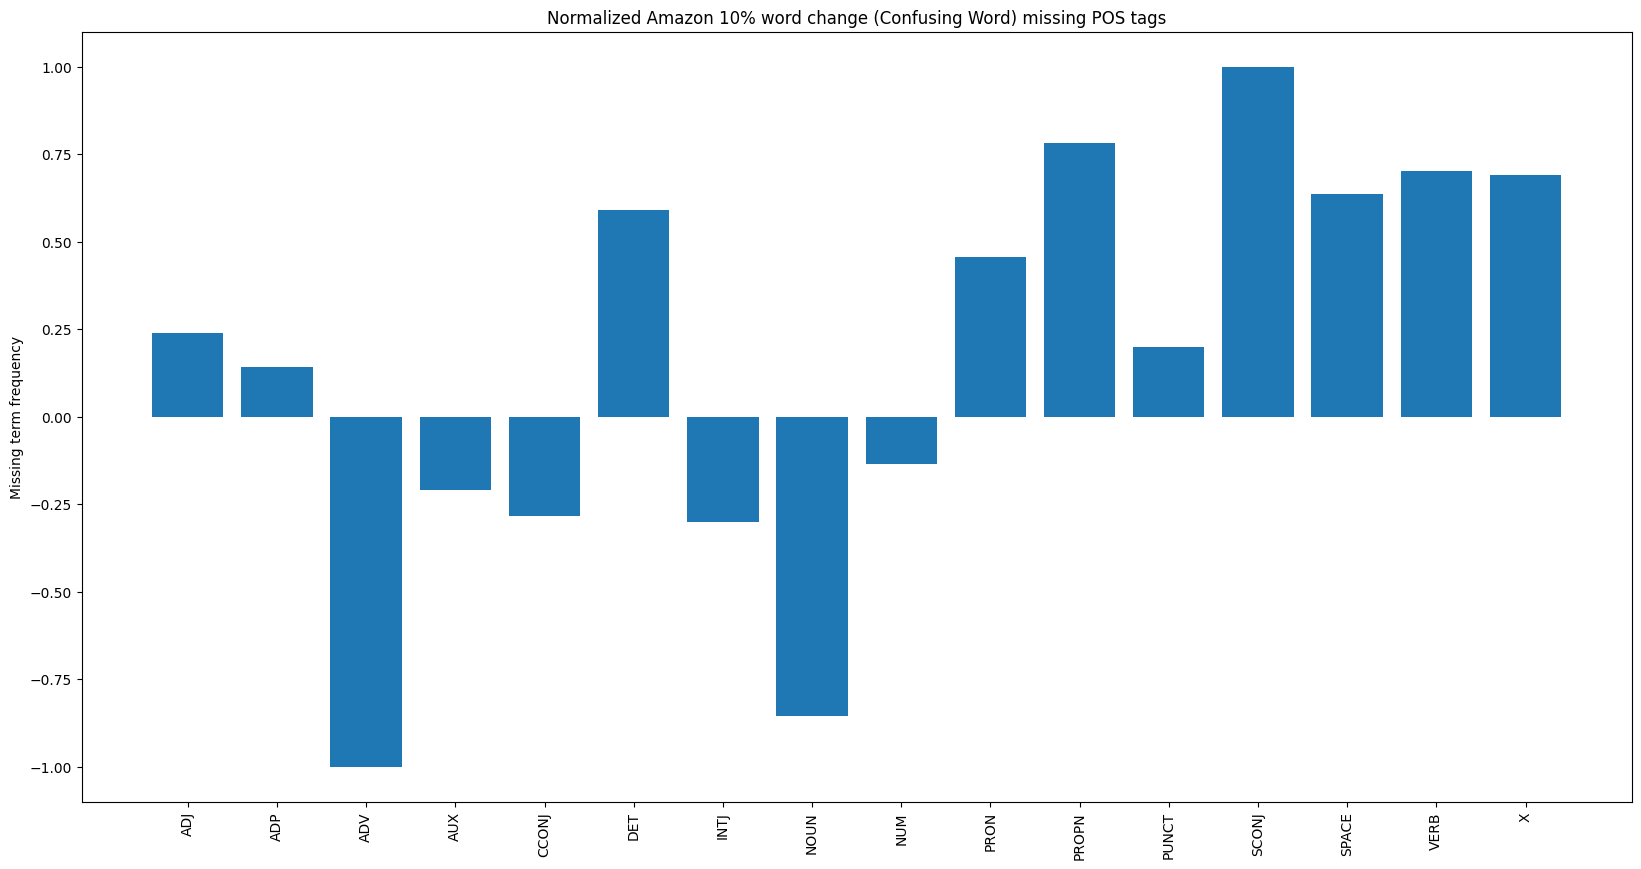

In [76]:

#confusing word 10% amazon
data_to_plot = missing_amazon_tags_dict_10_confusing_word
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
normalizer = MinMaxScaler(feature_range=(-1, 1))
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
#y_data = [y / max(y_data) for y in y_data]
y_data = [y[0] for y in y_data]
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Normalized Amazon 10% word change (Confusing Word) missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.show()


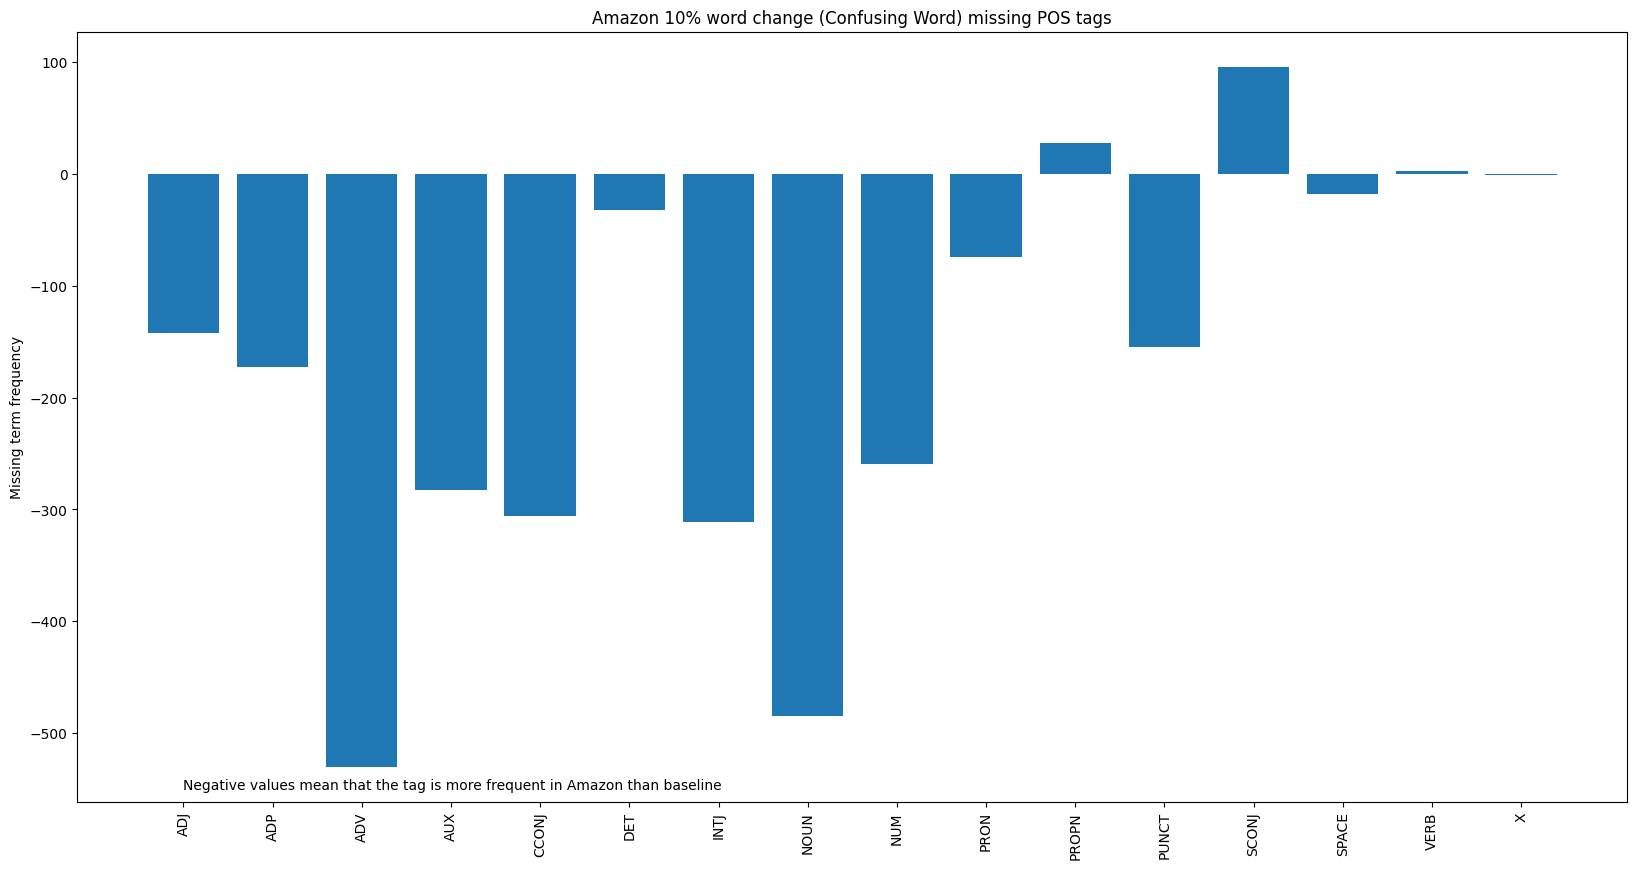

In [26]:
#confusing word 10% amazon
data_to_plot = missing_amazon_tags_dict_10_confusing_word
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Amazon 10% word change (Confusing Word) missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.text(0, -550, "Negative values mean that the tag is more frequent in Amazon than baseline", fontsize=10)
plt.show()


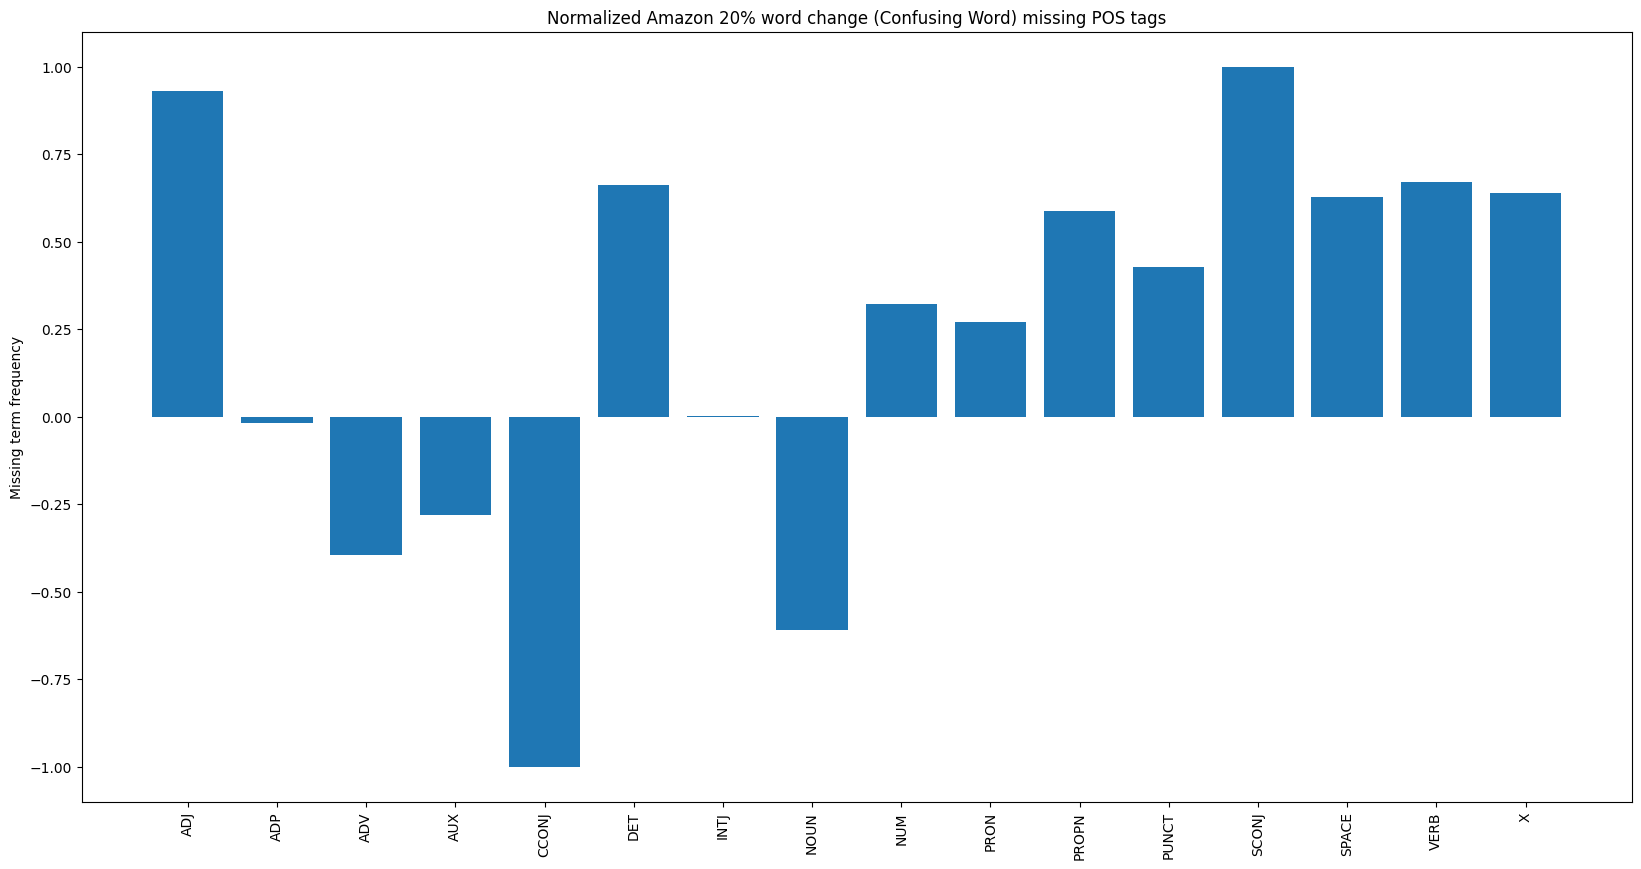

In [77]:
#confusing word 10% amazon
data_to_plot = missing_amazon_tags_dict_20_confusing_word
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
normalizer = MinMaxScaler(feature_range=(-1, 1))
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
#y_data = [y / max(y_data) for y in y_data]
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Normalized Amazon 20% word change (Confusing Word) missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.show()


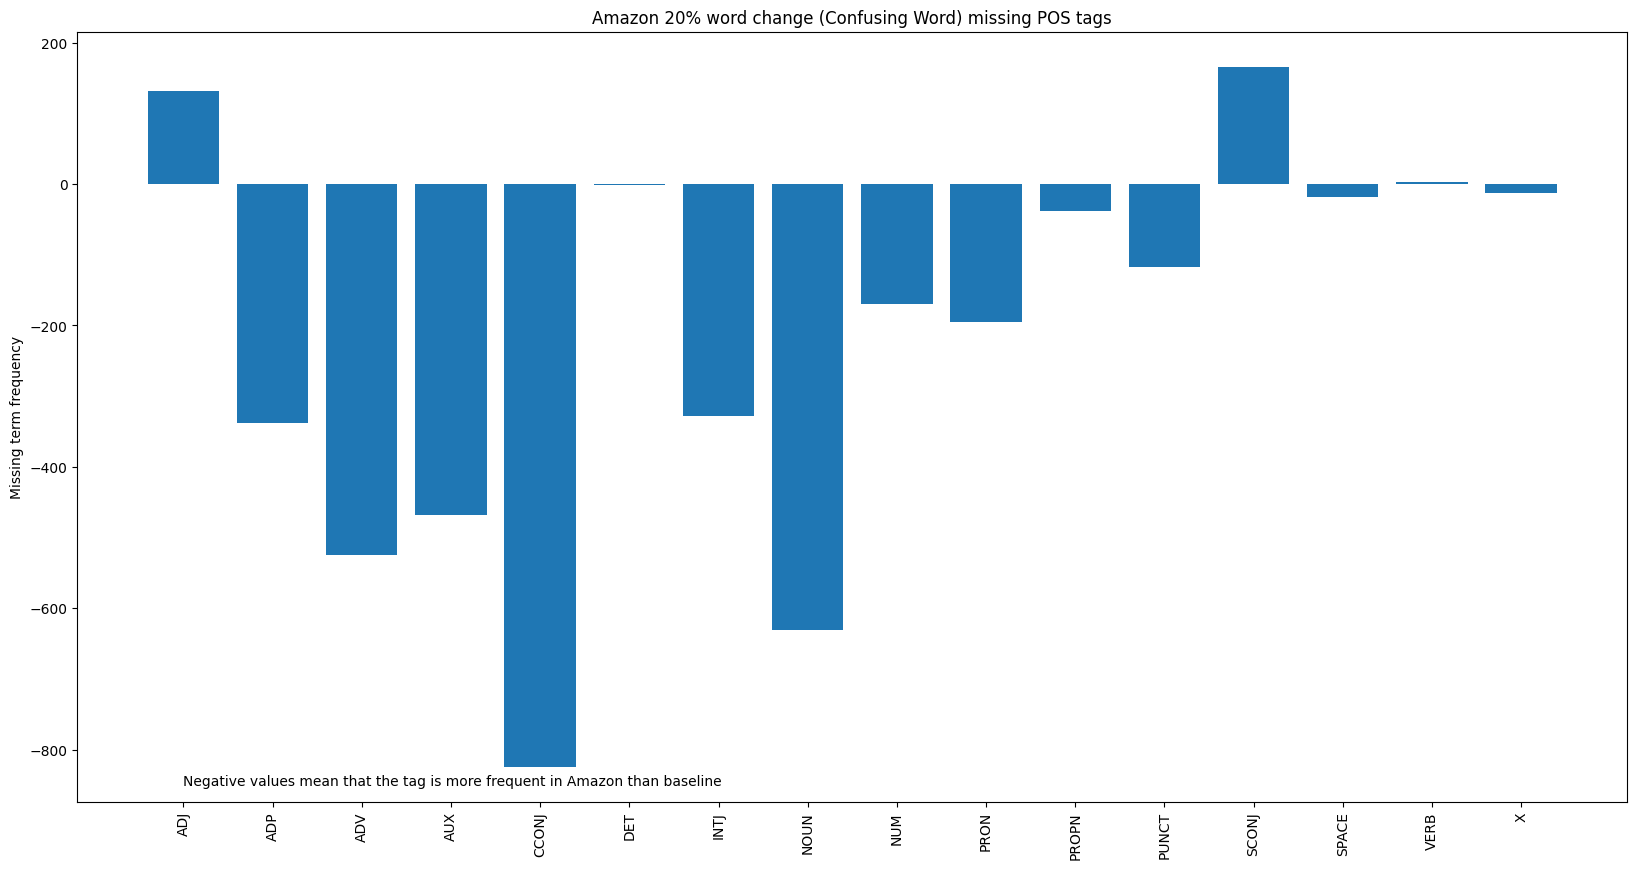

In [27]:
#confusing word 10% amazon
data_to_plot = missing_amazon_tags_dict_20_confusing_word
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Amazon 20% word change (Confusing Word) missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.text(0, -850, "Negative values mean that the tag is more frequent in Amazon than baseline", fontsize=10)
plt.show()


In [28]:
#number of words for amazon 10% confusing word
print(f"Baseline number of words: {reference_corpus_fr.get_number_of_words()}")
print(f"Baseline Amazon number of words: {aws_data_v1[0].get_number_of_words()}")
print(f"Amazon 10% confusing word change number of words: {aws_data_v1[4].get_number_of_words()}")
print(f"Amazon 20% confusing word change number of words: {aws_data_v2[1].get_number_of_words()}")

Baseline number of words: 69569
Baseline Amazon number of words: 69911
Amazon 10% confusing word change number of words: 71985
Amazon 20% confusing word change number of words: 72607


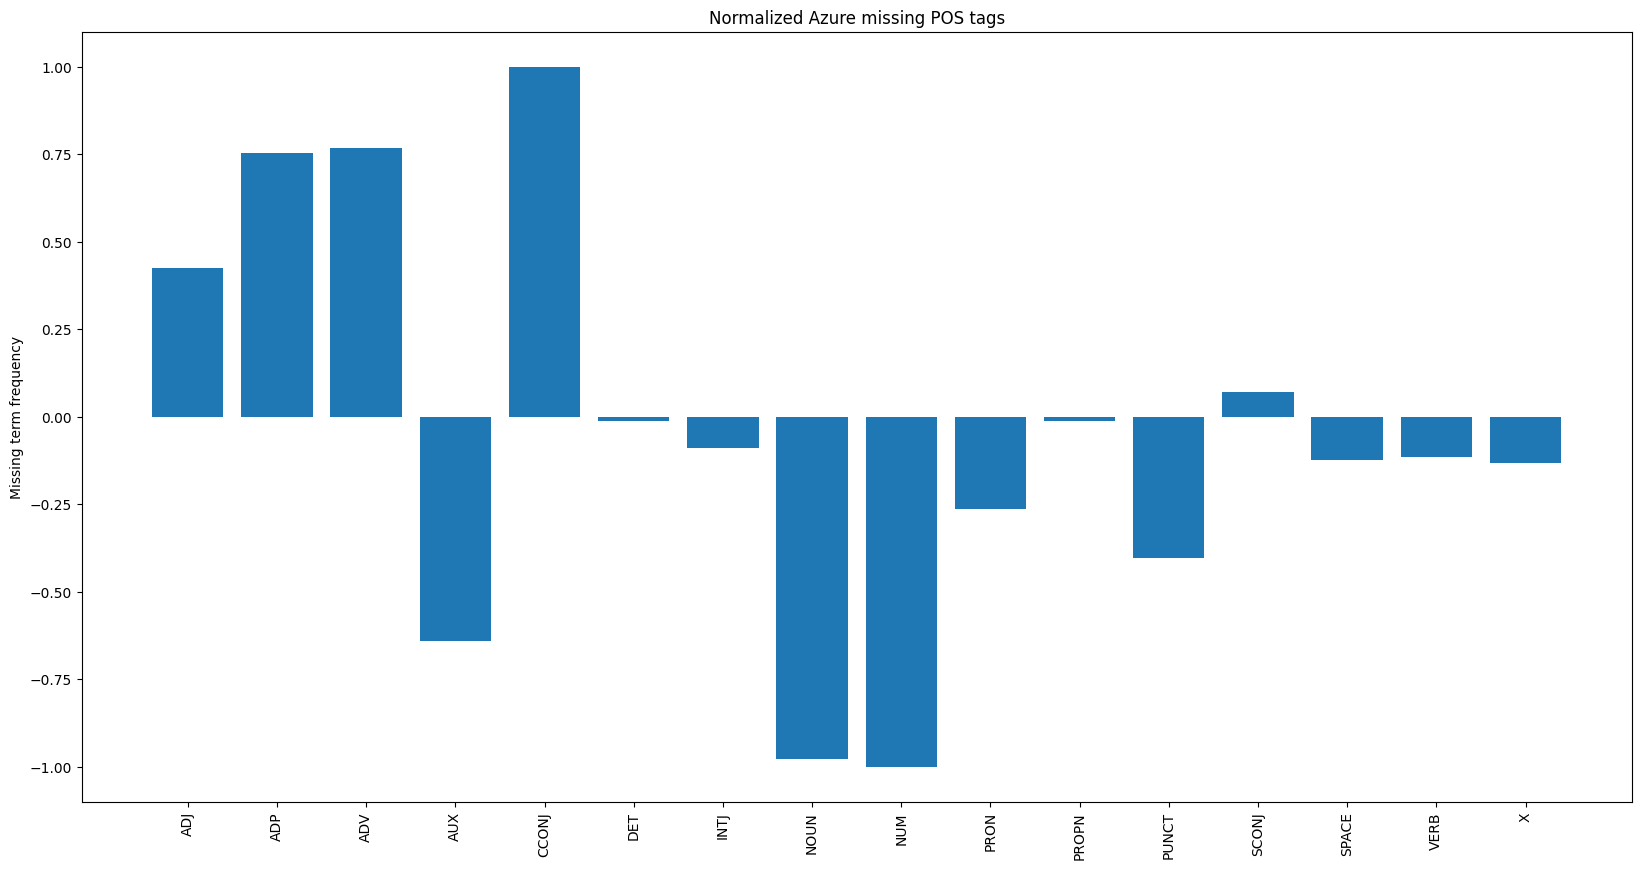

In [79]:
data_to_plot = missing_azure_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
normalizer = MinMaxScaler(feature_range=(-1, 1))
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
#y_data = [y / max(y_data) for y in y_data]
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Normalized Azure missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.show()

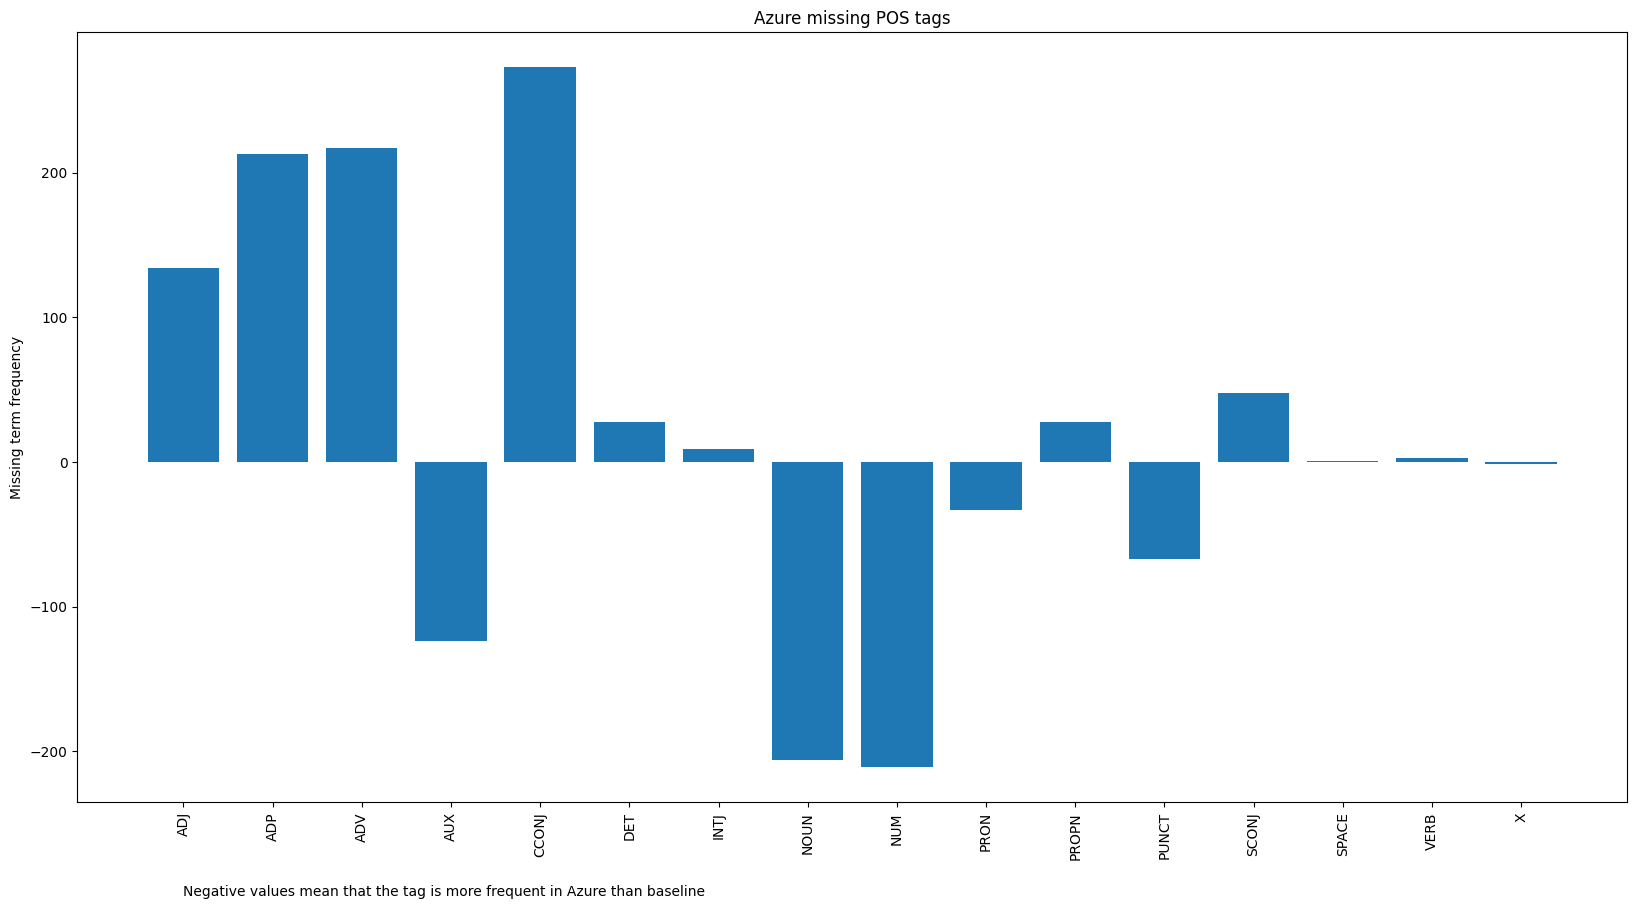

In [29]:
data_to_plot = missing_azure_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Azure missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.text(0, -300, "Negative values mean that the tag is more frequent in Azure than baseline", fontsize=10)
plt.show()

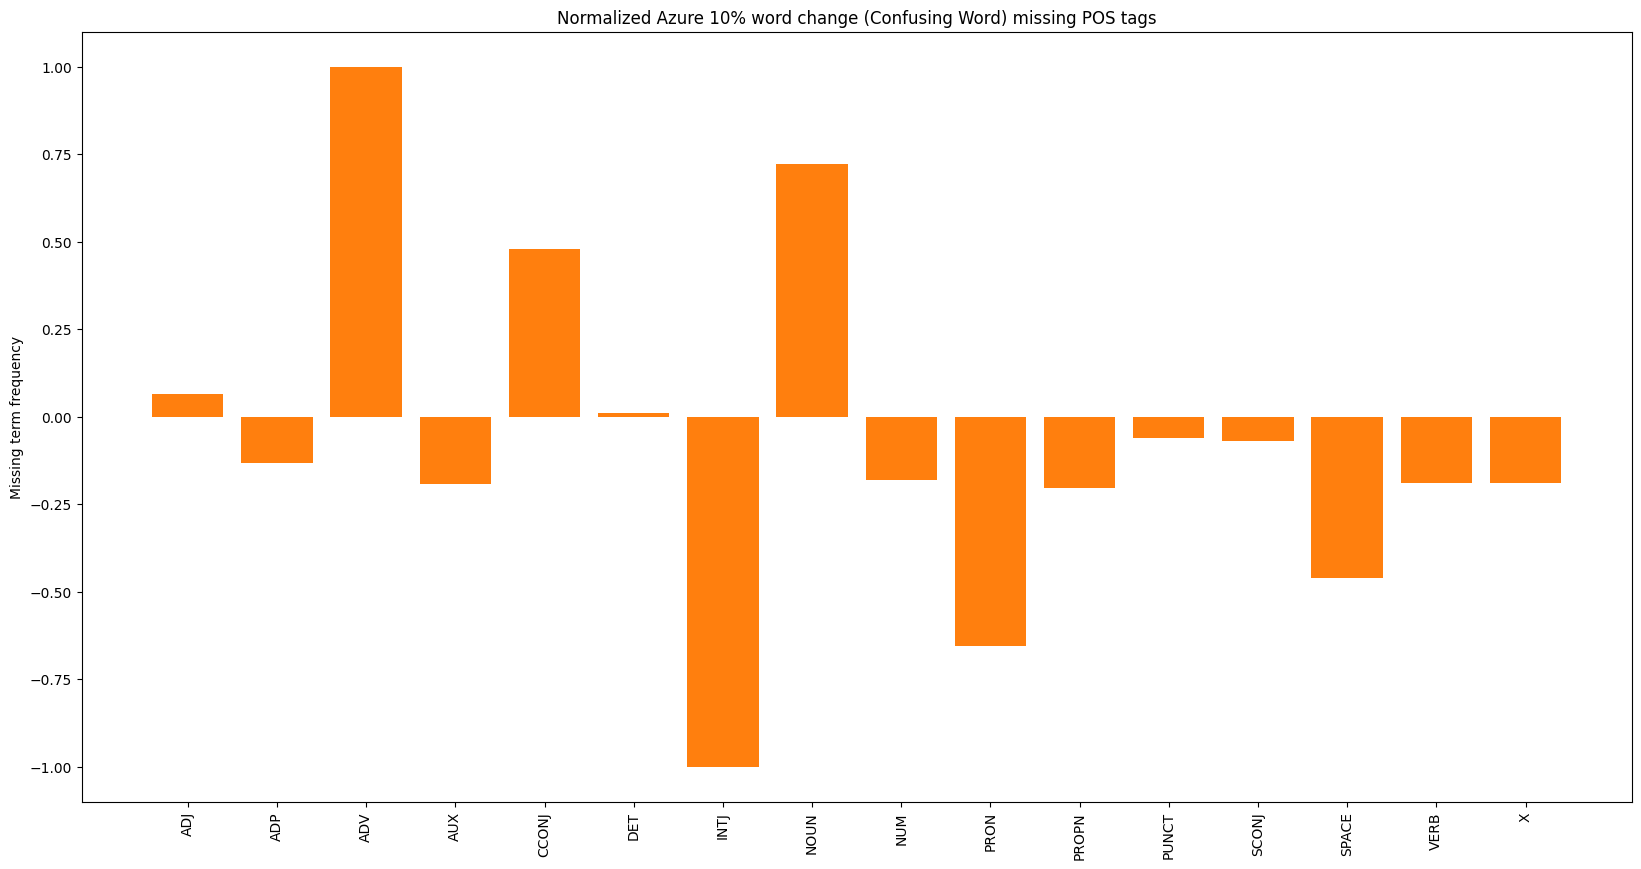

In [80]:

#10% confusing word azure
data_to_plot = missing_azure_tags_dict_10_confusing_word
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
normalizer = MinMaxScaler(feature_range=(-1, 1))
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
#y_data = [y / max(y_data) for y in y_data]
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Normalized Azure 10% word change (Confusing Word) missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.show()

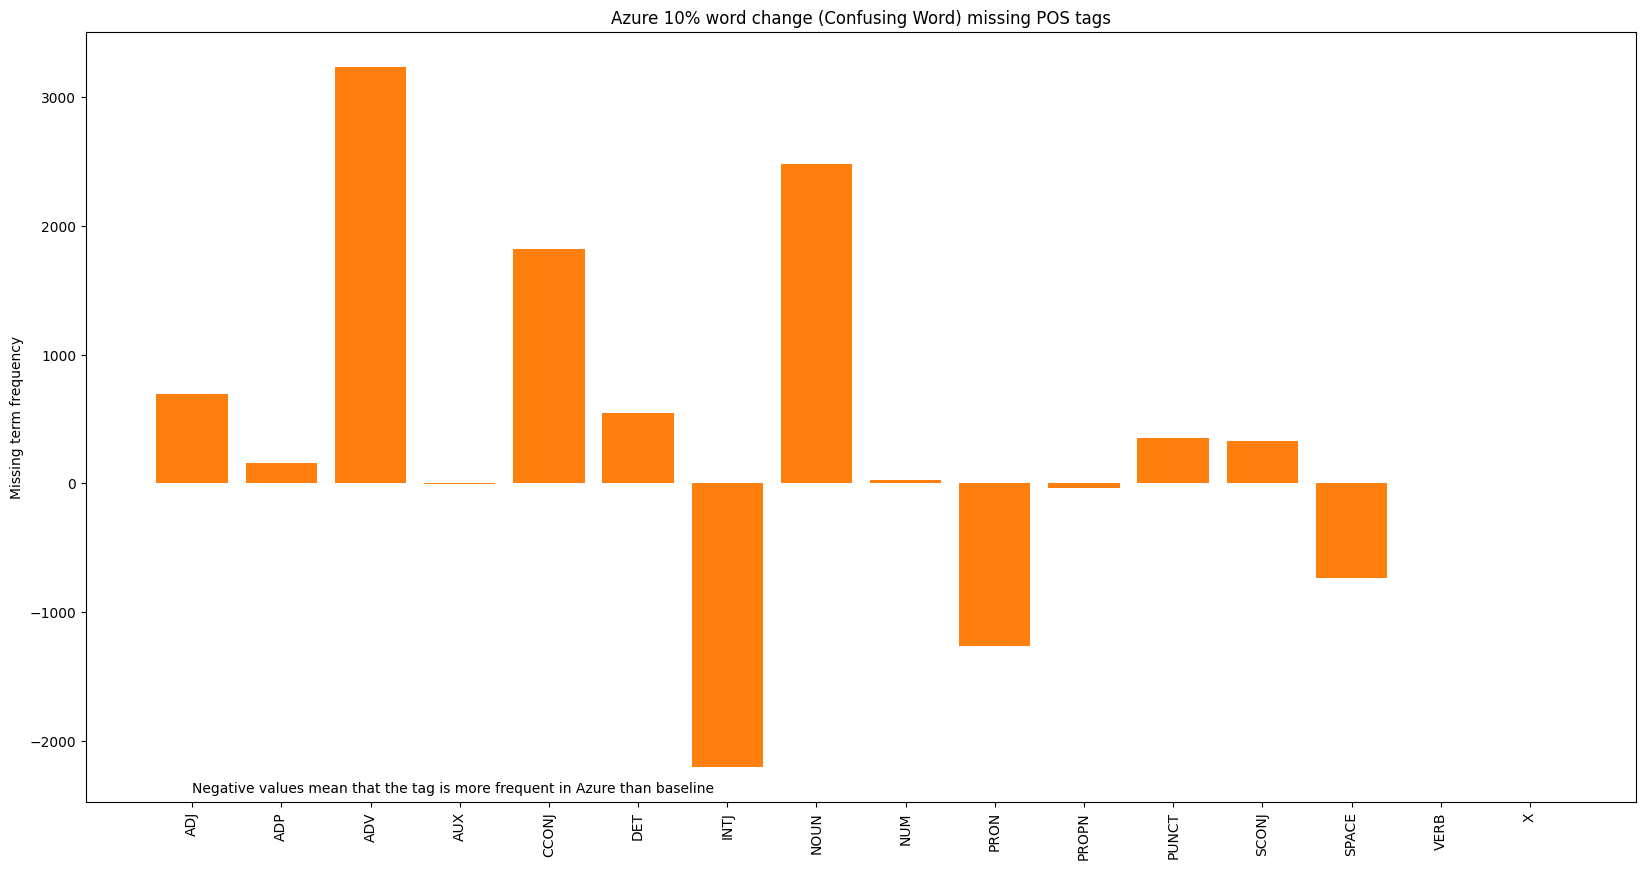

In [30]:
#10% confusing word azure
data_to_plot = missing_azure_tags_dict_10_confusing_word
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Azure 10% word change (Confusing Word) missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.text(0, -2400, "Negative values mean that the tag is more frequent in Azure than baseline", fontsize=10)
plt.show()


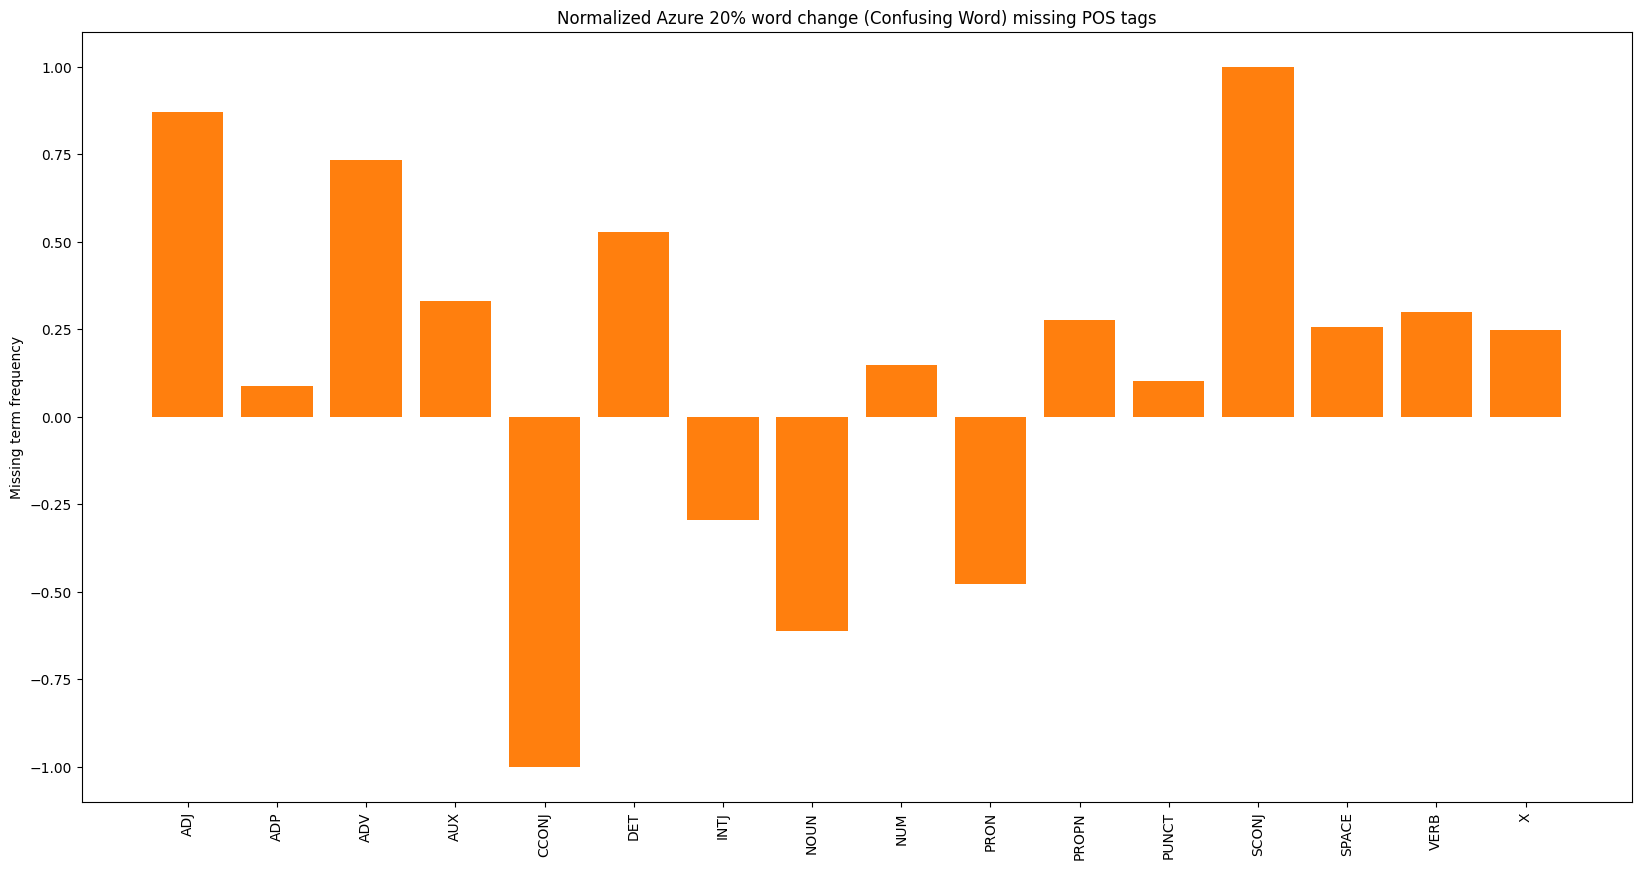

In [81]:
#10% confusing word azure
data_to_plot = missing_azure_tags_dict_20_confusing_word
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
normalizer = MinMaxScaler(feature_range=(-1, 1))
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
#y_data = [y / max(y_data) for y in y_data]
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Normalized Azure 20% word change (Confusing Word) missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.show()

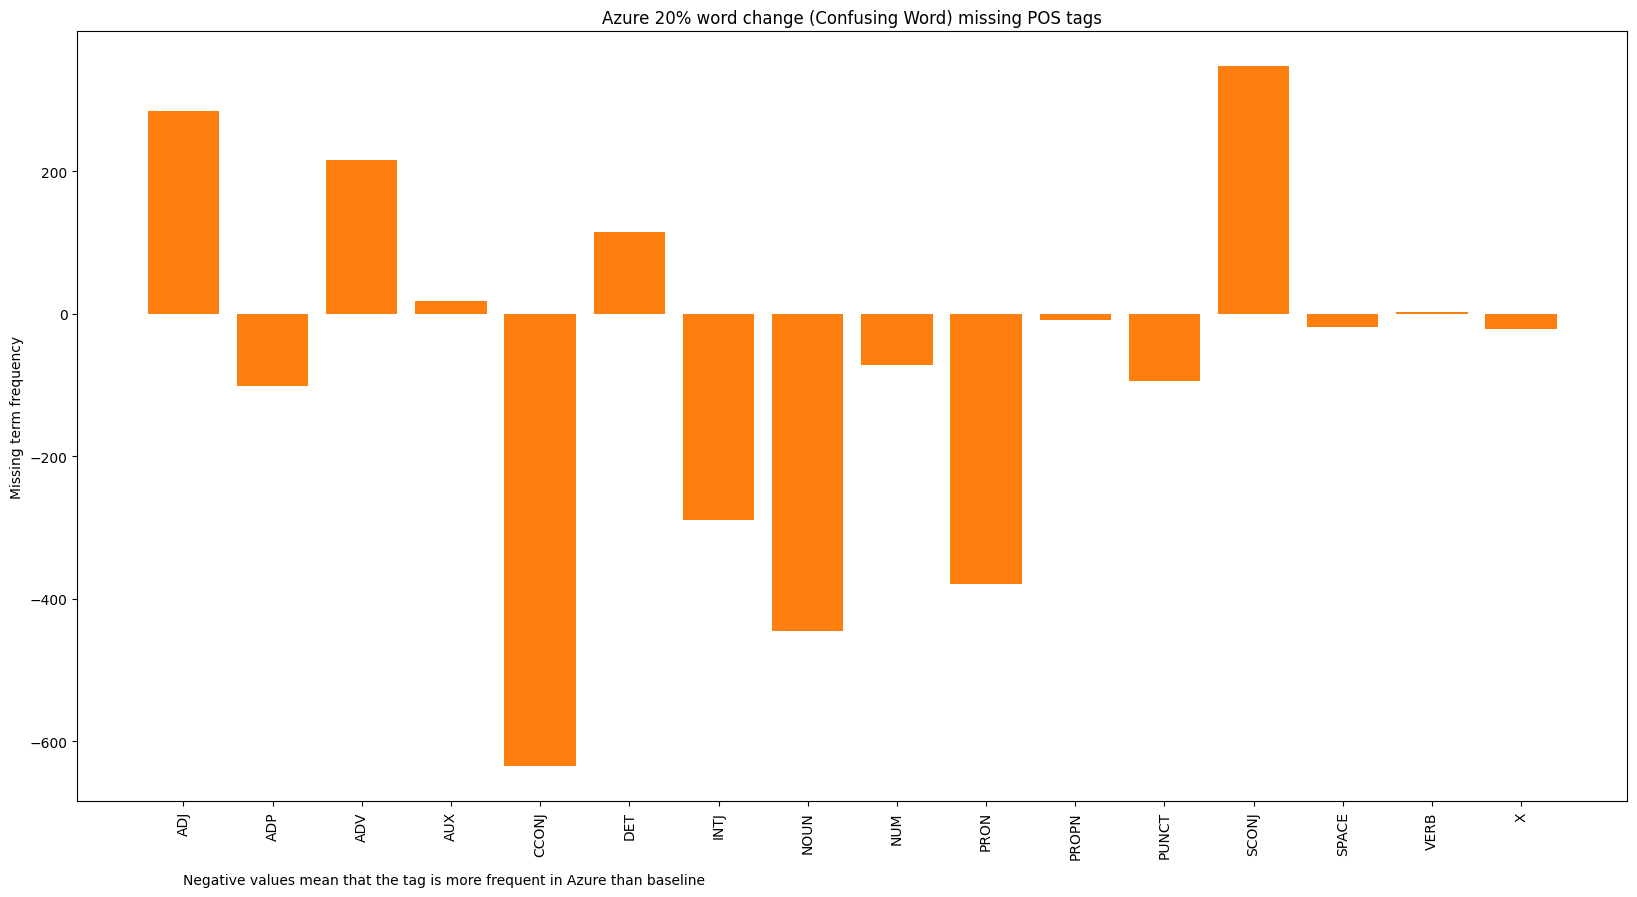

In [31]:
#10% confusing word azure
data_to_plot = missing_azure_tags_dict_20_confusing_word
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Azure 20% word change (Confusing Word) missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.text(0, -800, "Negative values mean that the tag is more frequent in Azure than baseline", fontsize=10)
plt.show()


In [32]:
#number of words for azure 10% confusing word
print(f"Baseline number of words: {reference_corpus_fr.get_number_of_words()}")
print(f"Baseline Azure number of words: {azure_data_v1[0].get_number_of_words()}")
print(f"Azure 10% confusing word change number of words: {azure_data_v1[4].get_number_of_words()}")
print(f"Azure 20% confusing word change number of words: {azure_data_v2[1].get_number_of_words()}")


Baseline number of words: 69569
Baseline Azure number of words: 69290
Azure 10% confusing word change number of words: 65195
Azure 20% confusing word change number of words: 70956


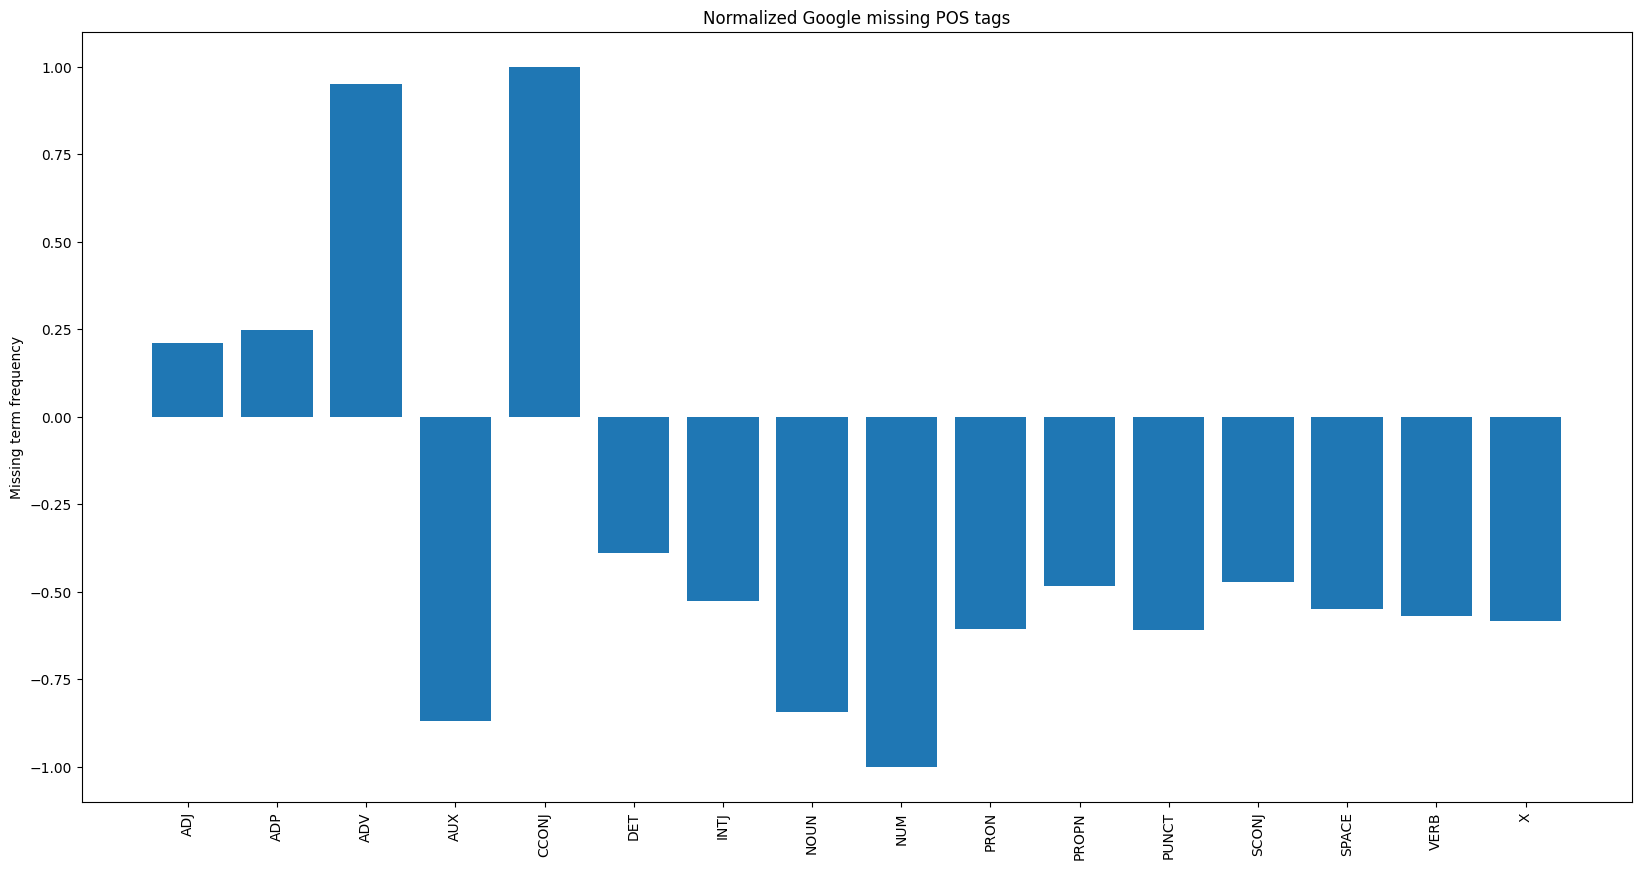

In [83]:

data_to_plot = missing_google_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
normalizer = MinMaxScaler(feature_range=(-1, 1))
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
#y_data = [y / max(y_data) for y in y_data]
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Normalized Google missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.show()

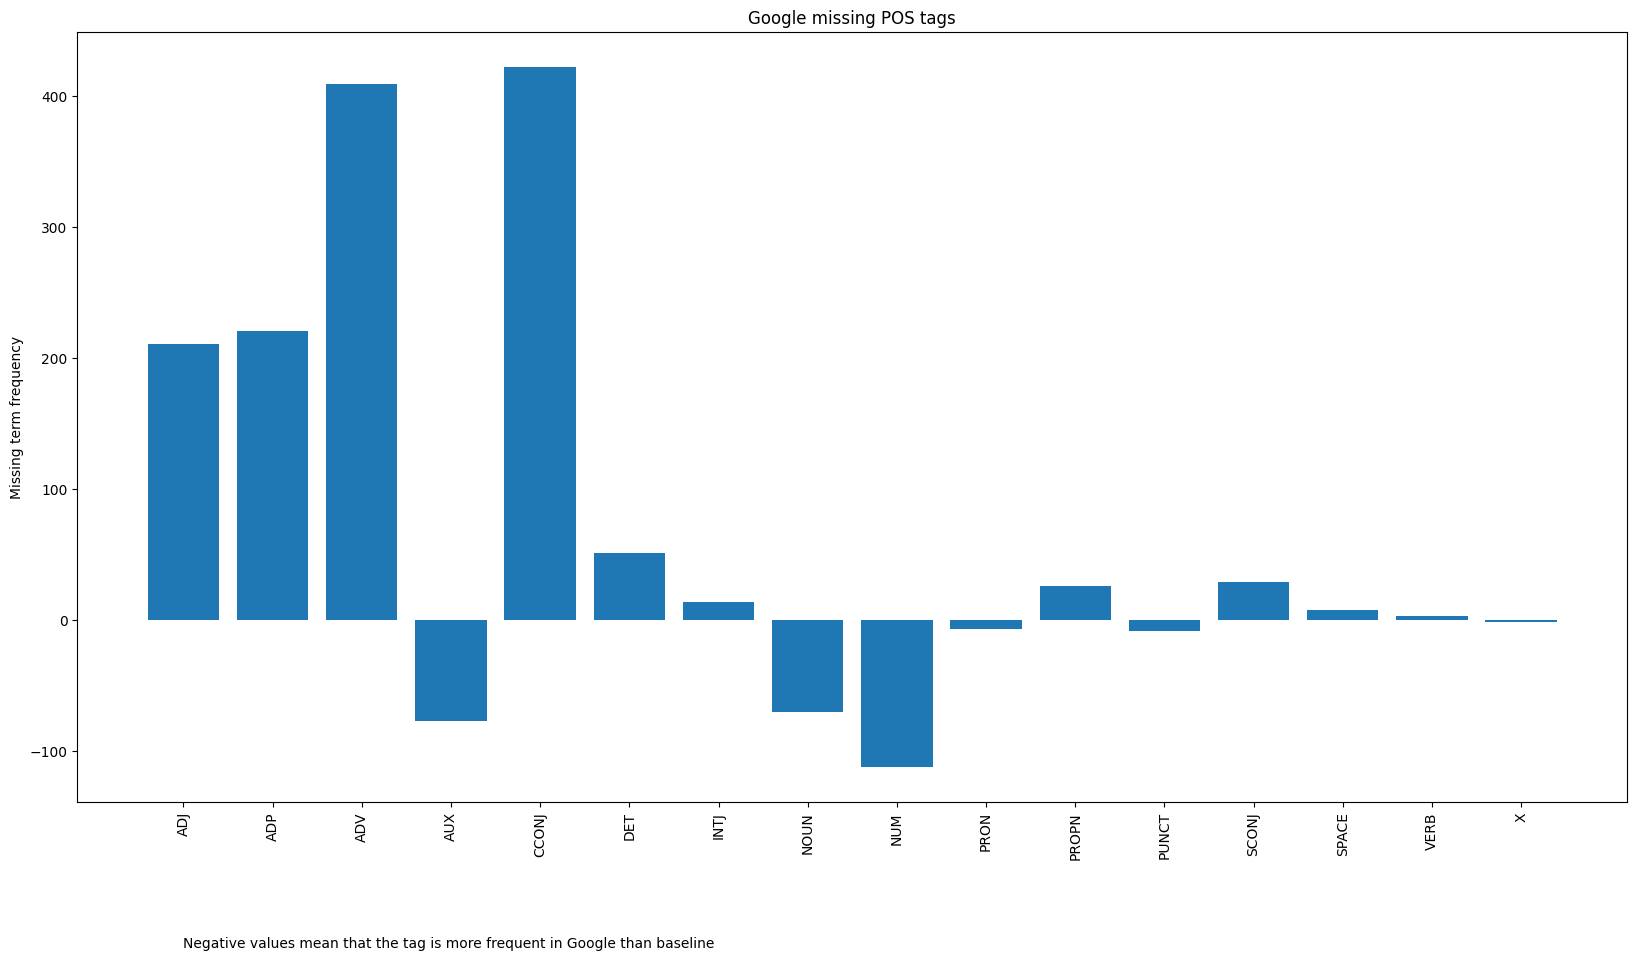

In [33]:
data_to_plot = missing_google_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Google missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.text(0, -250, "Negative values mean that the tag is more frequent in Google than baseline", fontsize=10)
plt.show()

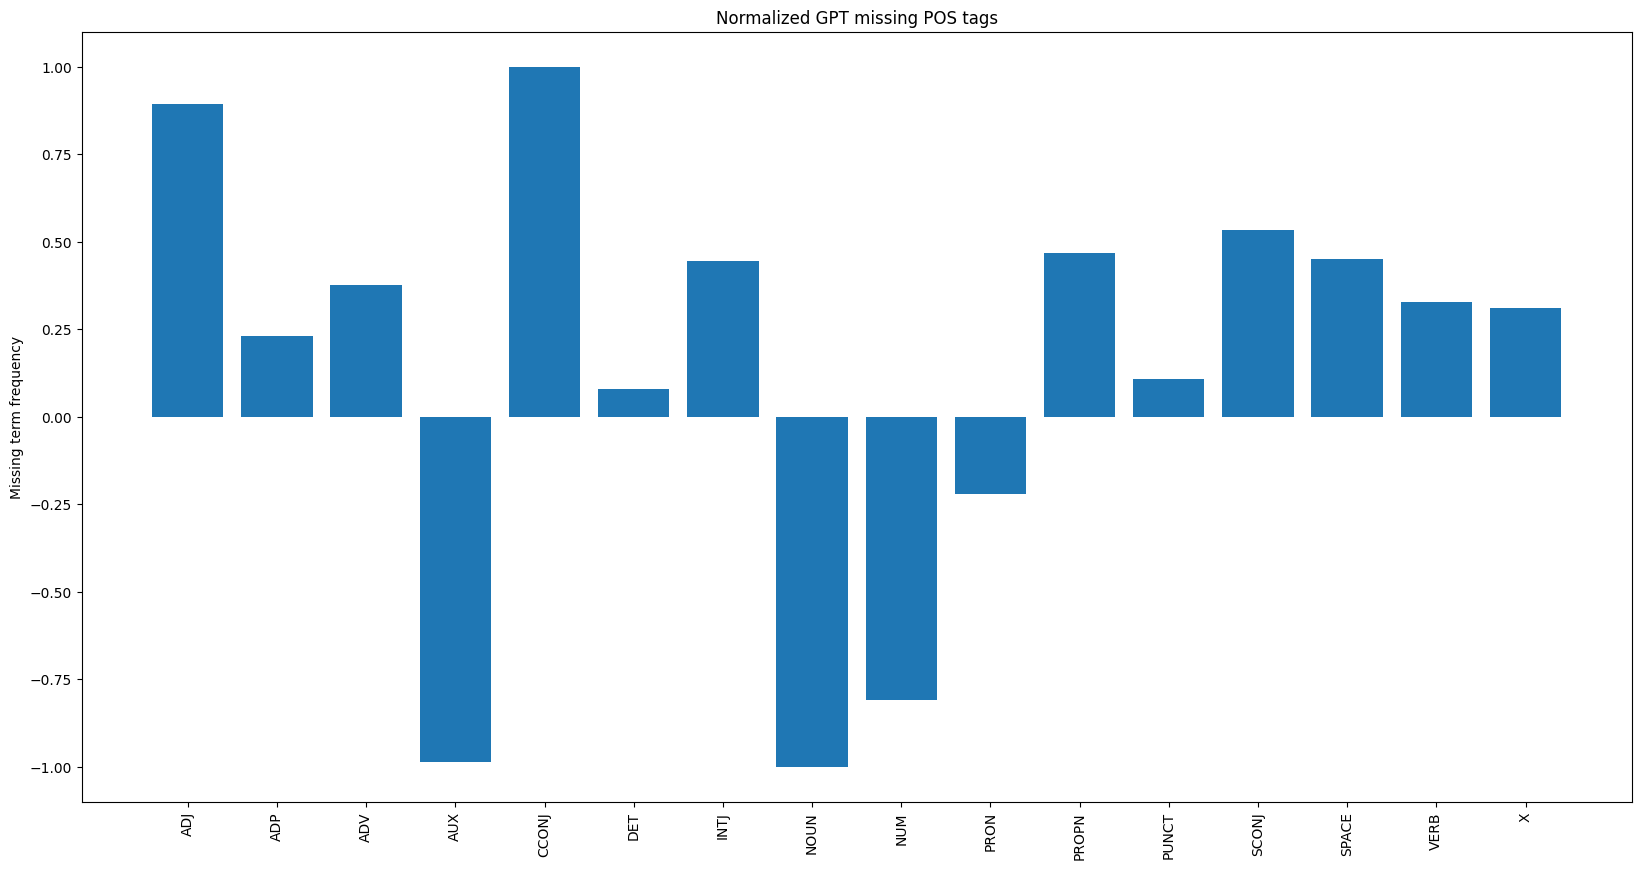

In [84]:


data_to_plot = missing_gpt_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
normalizer = MinMaxScaler(feature_range=(-1, 1))
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
#y_data = [y / max(y_data) for y in y_data]
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("Normalized GPT missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.show()

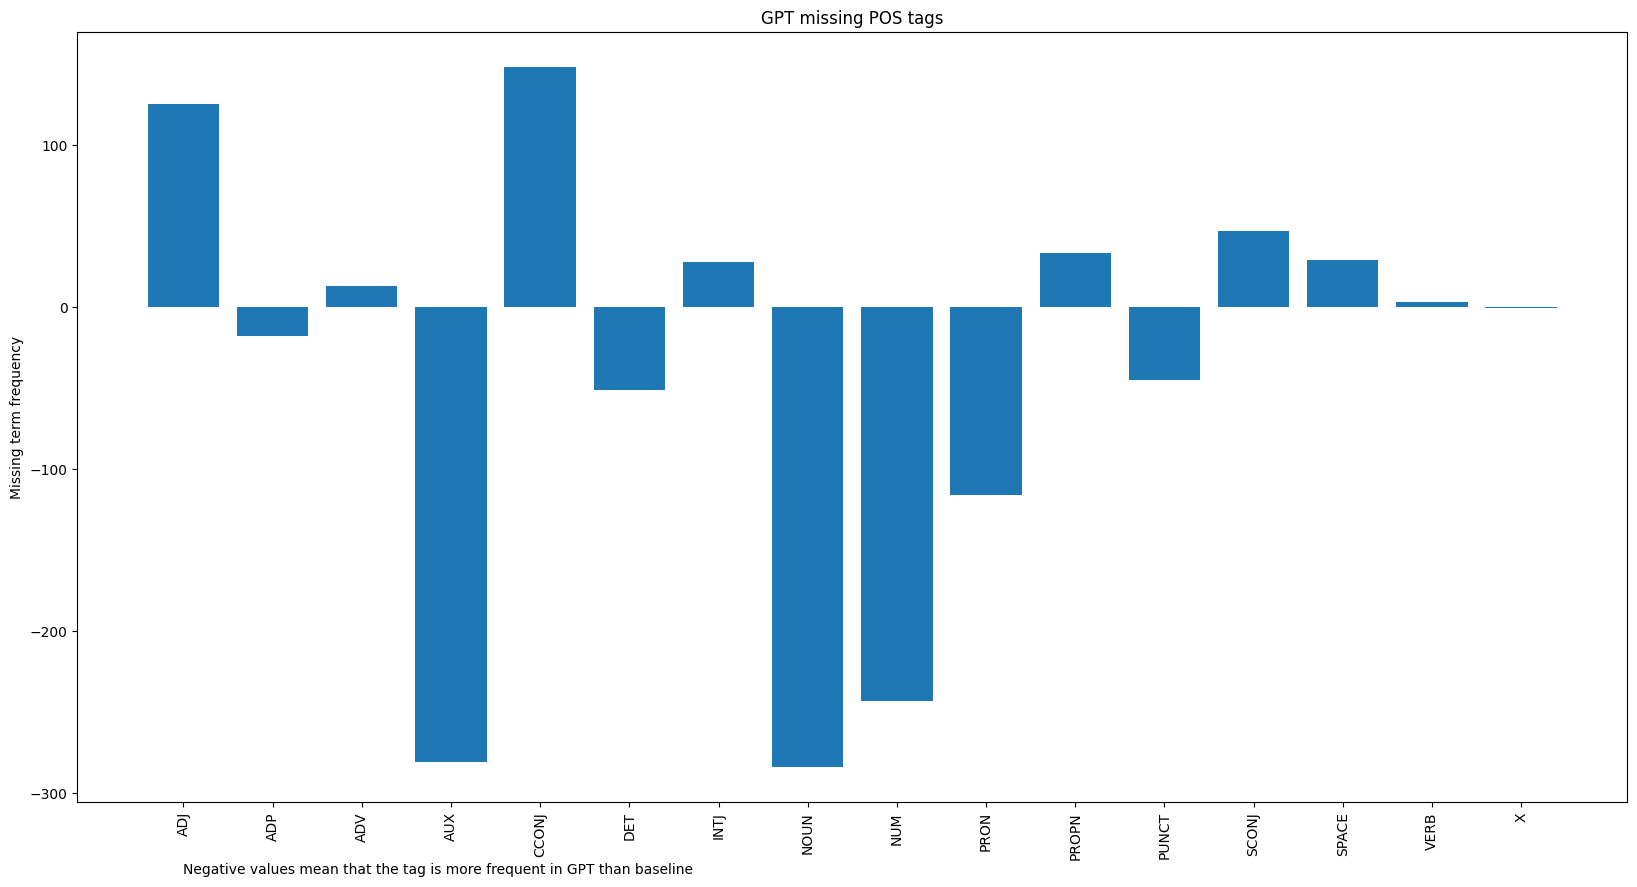

In [34]:
data_to_plot = missing_gpt_tags_dict
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
y_data = list(data_to_plot.values())
#y_data = [y / max(y_data) for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Missing term frequency")
plt.title("GPT missing POS tags")
#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
#add note to say that negative values mean that the tag is more frequent in amazon than baseline
plt.text(0, -350, "Negative values mean that the tag is more frequent in GPT than baseline", fontsize=10)
plt.show()

In [35]:
baseline_words_dict={}
for sentence in reference_corpus_fr.get_data():
    #strip any punctuation
    sentence = re.sub(r'[^\w\s]','',sentence)
    #lowercase
    sentence = sentence.lower()
    sentence = sentence.split()
    for word in sentence:
        if word not in baseline_words_dict:
            baseline_words_dict[word] = 1
        else:
            baseline_words_dict[word] += 1

amazon_words_dict = {}
for sentence in aws_data_v1[0].get_data():
    #strip any punctuation
    sentence = re.sub(r'[^\w\s]','',sentence)
    #lowercase
    sentence = sentence.lower()
    data = sentence.split()
    for word in data:
        if word not in amazon_words_dict:
            amazon_words_dict[word] = 1
        else:
            amazon_words_dict[word] += 1

google_words_dict = {}
for sentence in google_data_v1[0].get_data():
    #strip any punctuation
    sentence = re.sub(r'[^\w\s]','',sentence)
    #lowercase
    sentence = sentence.lower()
    data = sentence.split()
    for word in data:
        if word not in google_words_dict:
            google_words_dict[word] = 1
        else:
            google_words_dict[word] += 1

azure_words_dict = {}
for sentence in azure_data_v1[0].get_data():
    #strip any punctuation
    sentence = re.sub(r'[^\w\s]','',sentence)
    #lowercase
    sentence = sentence.lower()
    data = sentence.split()
    for word in data:
        if word not in azure_words_dict:
            azure_words_dict[word] = 1
        else:
            azure_words_dict[word] += 1

gpt_words_dict = {}
for sentence in gpt_data_v1[0].get_data():
    #strip any punctuation
    sentence = re.sub(r'[^\w\s]','',sentence)
    #lowercase
    sentence = sentence.lower()
    data = sentence.split()
    for word in data:
        if word not in gpt_words_dict:
            gpt_words_dict[word] = 1
        else:
            gpt_words_dict[word] += 1
       

In [36]:
#lets compare sentence by sentence the words
missing_words_amazon = diff_tags_dicts(baseline_words_dict, amazon_words_dict)
missing_words_google = diff_tags_dicts(baseline_words_dict, google_words_dict)
missing_words_azure = diff_tags_dicts(baseline_words_dict, azure_words_dict)
missing_words_gpt = diff_tags_dicts(baseline_words_dict, gpt_words_dict)

In [37]:
#print the top 20 highest values in missing_words_amazon
sorted_missing_words_amazon = sorted(missing_words_amazon.items(), key=lambda x: x[1], reverse=True)
print(f"Amazon most commonly missing words:\n {sorted_missing_words_amazon[:20]}")
#print the bottom 20 lowest values in missing_words_amazon
print(f"Amazon most commonly added words:\n {sorted_missing_words_amazon[-20:]}")

#print the top 20 highest values in missing_words_google
sorted_missing_words_google = sorted(missing_words_google.items(), key=lambda x: x[1], reverse=True)
print(f"Google most commonly missing words:\n {sorted_missing_words_google[:20]}")
#print the bottom 20 lowest values in missing_words_google
print(f"Google most commonly added words:\n {sorted_missing_words_google[-20:]}")

#print the top 20 highest values in missing_words_azure
sorted_missing_words_azure = sorted(missing_words_azure.items(), key=lambda x: x[1], reverse=True)
print(f"Azure most commonly missing words:\n {sorted_missing_words_azure[:20]}")
#print the bottom 20 lowest values in missing_words_azure
print(f"Azure most commonly added words:\n {sorted_missing_words_azure[-20:]}")

#print the top 20 highest values in missing_words_gpt
sorted_missing_words_gpt = sorted(missing_words_gpt.items(), key=lambda x: x[1], reverse=True)
print(f"GPT most commonly missing words:\n {sorted_missing_words_gpt[:20]}")
#print the bottom 20 lowest values in missing_words_gpt
print(f"GPT most commonly added words:\n {sorted_missing_words_gpt[-20:]}")




Amazon most commonly missing words:
 [('on', 82), ('m', 50), ('en', 48), ('son', 47), ('aussi', 45), ('sur', 44), ('qui', 38), ('dit', 37), ('une', 29), ('expliqué', 28), ('ça', 27), ('a', 24), ('etatsunis', 24), ('la', 23), ('avec', 23), ('ajouté', 22), ('un', 21), ('au', 21), ('sans', 19), ('se', 18)]
Amazon most commonly added words:
 [('lors', -21), ('jai', -21), ('sest', -21), ('étatsunis', -23), ('par', -25), ('nous', -25), ('ont', -26), ('millions', -36), ('cela', -38), ('selon', -42), ('explique', -43), ('dune', -46), ('également', -49), ('été', -56), ('déclaré', -60), ('le', -69), ('dollars', -71), ('que', -72), ('à', -92), ('de', -211)]
Google most commonly missing words:
 [('en', 135), ('on', 85), ('qui', 62), ('du', 52), ('des', 50), ('m', 49), ('à', 38), ('son', 38), ('indiqué', 37), ('ce', 34), ('se', 32), ('elle', 31), ('aussi', 24), ('au', 23), ('la', 22), ('leur', 22), ('cette', 21), ('par', 20), ('toutefois', 19), ('expliqué', 19)]
Google most commonly added words:
 [

In [47]:
from collections import Counter

missing_extra_tags_amazon = []
missing_extra_tags_google = []
missing_extra_tags_azure = []
missing_extra_tags_gpt = []

for i in range(len(baseline_tags)):
    base = baseline_tags[i]
    #get the counts of
    amazon_diff = Counter(baseline_tags[i]) - Counter(amazon_baseline_tags[i])
    amazon_missing = [k for k, v in amazon_diff.items() for _ in range(int(v))]
    amazon_diff = Counter(amazon_baseline_tags[i]) - Counter(baseline_tags[i])
    amazon_extra = [k for k, v in amazon_diff.items() for _ in range(int(v))]
    missing_extra_tags_amazon.append((amazon_missing, amazon_extra))

    google_diff = Counter(baseline_tags[i]) - Counter(google_baseline_tags[i])
    google_missing = [k for k, v in google_diff.items() for _ in range(int(v))]
    google_diff = Counter(google_baseline_tags[i]) - Counter(baseline_tags[i])
    google_extra = [k for k, v in google_diff.items() for _ in range(int(v))]
    missing_extra_tags_google.append((google_missing, google_extra))

    azure_diff = Counter(baseline_tags[i]) - Counter(azure_baseline_tags[i])
    azure_missing = [k for k, v in azure_diff.items() for _ in range(int(v))]
    azure_diff = Counter(azure_baseline_tags[i]) - Counter(baseline_tags[i])
    azure_extra = [k for k, v in azure_diff.items() for _ in range(int(v))]
    missing_extra_tags_azure.append((azure_missing, azure_extra))

    gpt_diff = Counter(baseline_tags[i]) - Counter(gpt_baseline_tags[i])
    gpt_missing = [k for k, v in gpt_diff.items() for _ in range(int(v))]
    gpt_diff = Counter(gpt_baseline_tags[i]) - Counter(baseline_tags[i])
    gpt_extra = [k for k, v in gpt_diff.items() for _ in range(int(v))]
    missing_extra_tags_gpt.append((gpt_missing, gpt_extra))
    
    #ignores the count of each tag and just looks at the tags themselves

    A= [1,1,1,3,4]
    B= [1,2.3]


    [1,4] 

In [48]:
#https://docs.python.org/3/library/difflib.html
#https://huggingface.co/spaces/evaluate-metric/bertscore

In [49]:
missing_extra_tags_amazon[0]

(['PRON', 'VERB', 'PUNCT', 'PUNCT'], ['PROPN', 'ADJ'])

In [50]:
baseline_tags[0]

['PRON', 'VERB', 'ADP', 'PUNCT', 'NOUN', 'PUNCT', 'ADV', 'ADP', 'PROPN']

In [51]:
amazon_baseline_tags[0]

['PROPN', 'ADJ', 'ADP', 'NOUN', 'ADV', 'ADP', 'PROPN']

In [52]:
#lets sum up the number of missing and extra tags for each dataset

def get_tags_result(missing_extra_tags,value):
    output = {}
    for i in range(len(missing_extra_tags)):
        for tag in missing_extra_tags[i][value]:
            if tag not in output:
                output[tag] = 1
            else:
                output[tag] += 1
    return output


amazon_res_missing = get_tags_result(missing_extra_tags_amazon, 0)
amazon_res_extra = get_tags_result(missing_extra_tags_amazon, 1)
google_res_missing = get_tags_result(missing_extra_tags_google, 0)
google_res_extra = get_tags_result(missing_extra_tags_google, 1)
azure_res_missing = get_tags_result(missing_extra_tags_azure, 0)
azure_res_extra = get_tags_result(missing_extra_tags_azure, 1)
gpt_res_missing = get_tags_result(missing_extra_tags_gpt, 0)
gpt_res_extra = get_tags_result(missing_extra_tags_gpt, 1)




In [53]:
amazon_res_missing

{'PRON': 882,
 'VERB': 917,
 'PUNCT': 651,
 'ADJ': 785,
 'NOUN': 1378,
 'ADV': 624,
 'ADP': 1275,
 'PROPN': 389,
 'DET': 874,
 'SCONJ': 257,
 'CCONJ': 209,
 'AUX': 544,
 'X': 36,
 'NUM': 76,
 'SPACE': 3,
 'INTJ': 1}

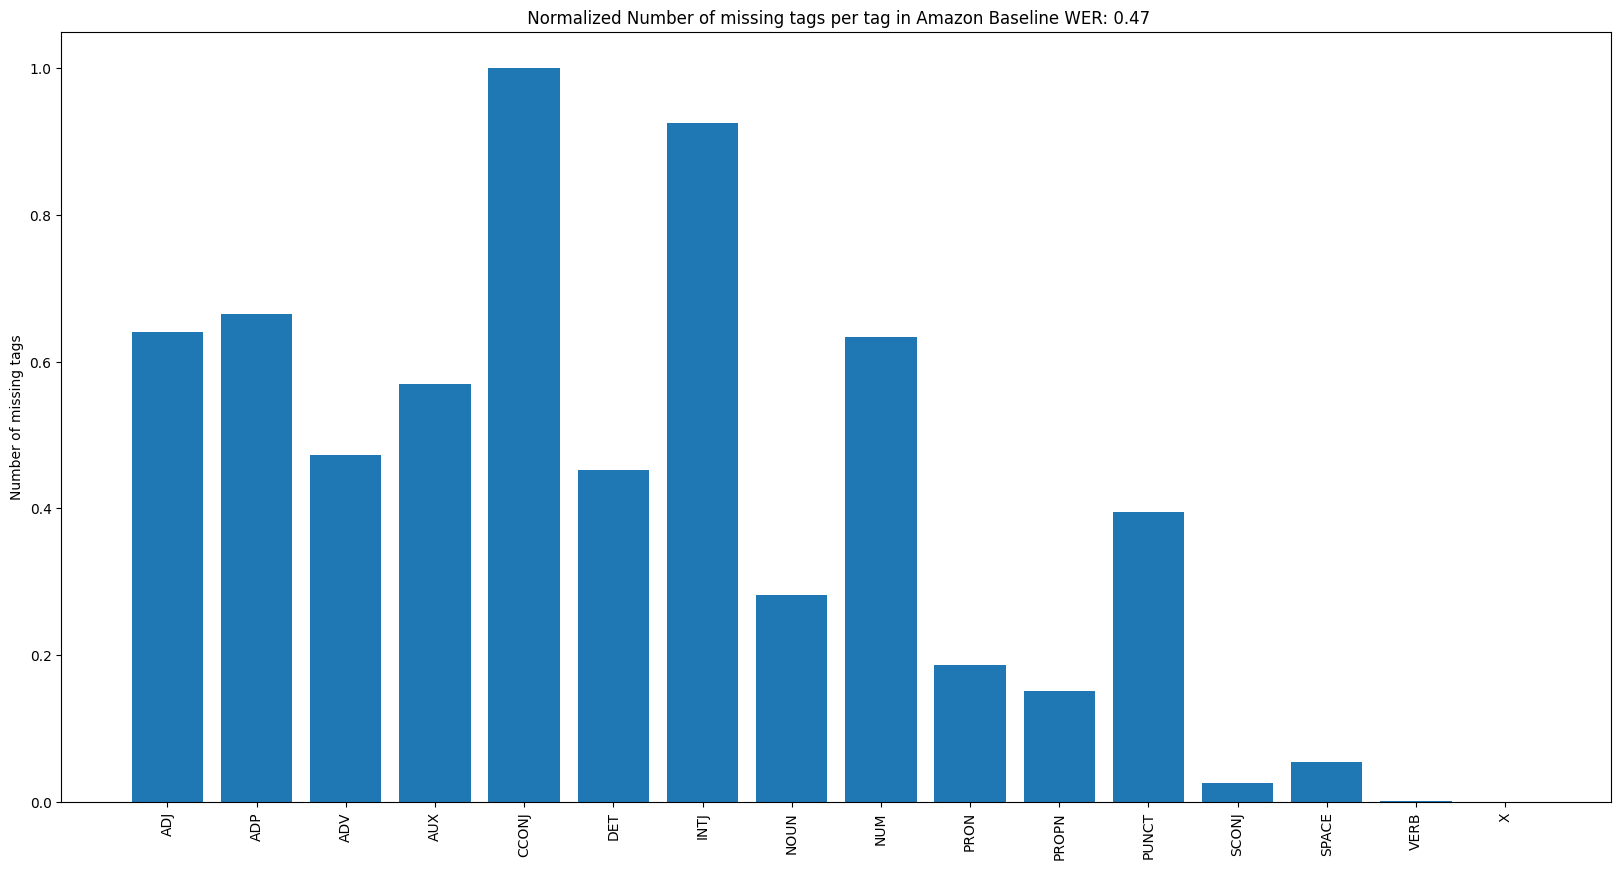

In [98]:
#lets make a bar chart of the missing tags
data_to_plot = amazon_res_missing
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
normalizer = MinMaxScaler(feature_range=(0, 1))
y_data = list(data_to_plot.values())
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of missing tags")
plt.title(f" Normalized Number of missing tags per tag in Amazon Baseline WER: {round(aws_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
# for i, v in enumerate(data_to_plot.values()):
#     plt.text(i, v, str(v), color='blue', fontweight='bold')

#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()



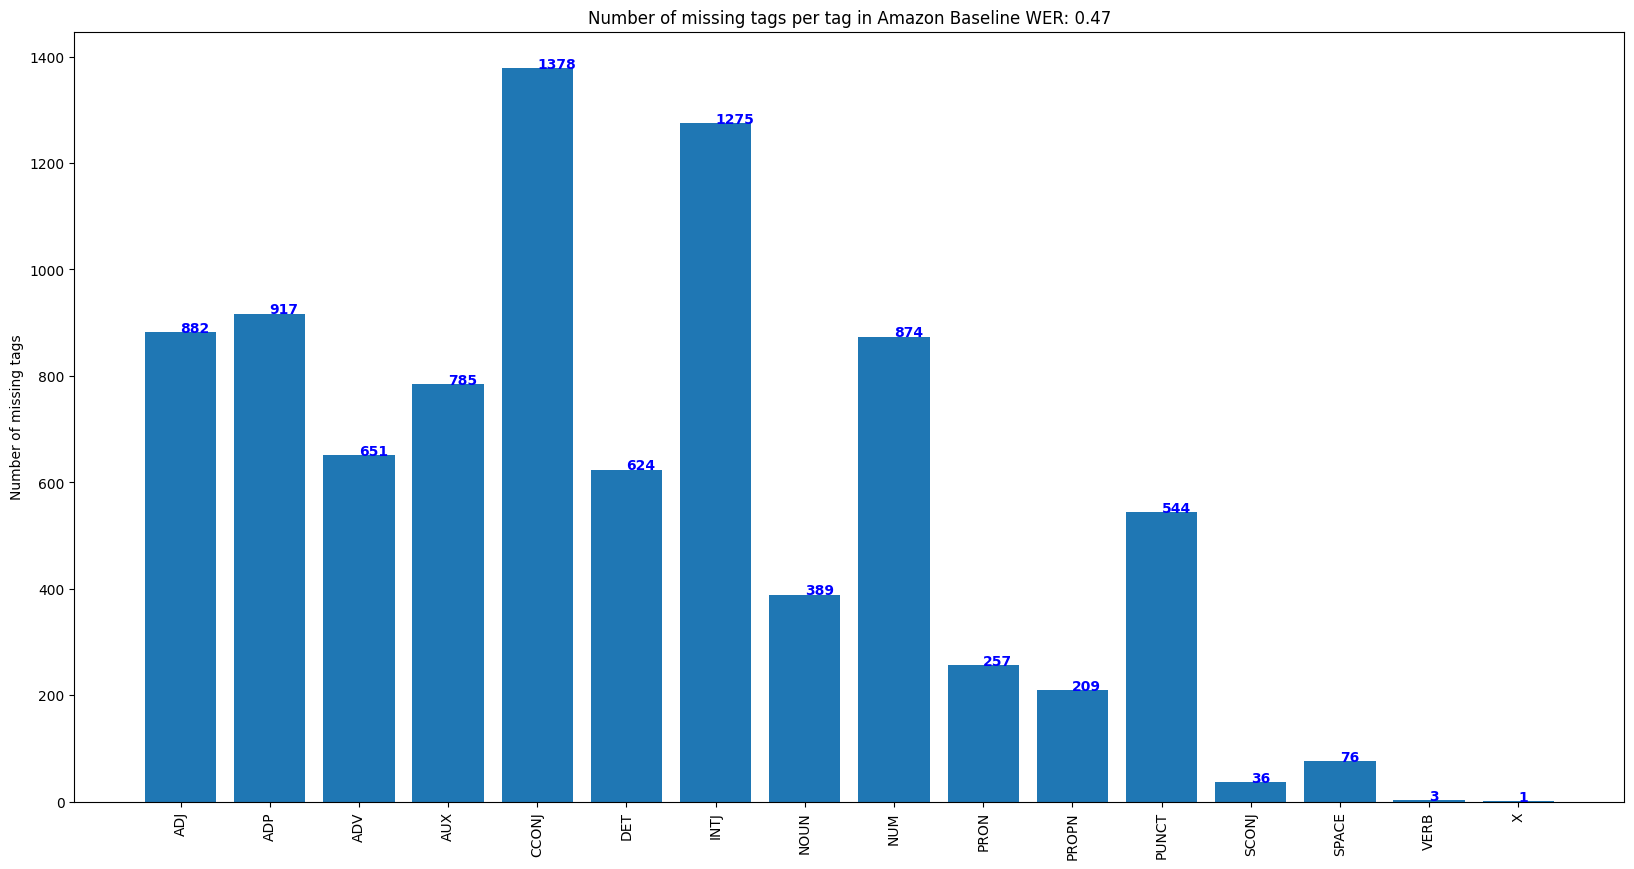

In [54]:
#lets make a bar chart of the missing tags
data_to_plot = amazon_res_missing
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of missing tags")
plt.title(f"Number of missing tags per tag in Amazon Baseline WER: {round(aws_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')

#order the x axis alphabetically
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()



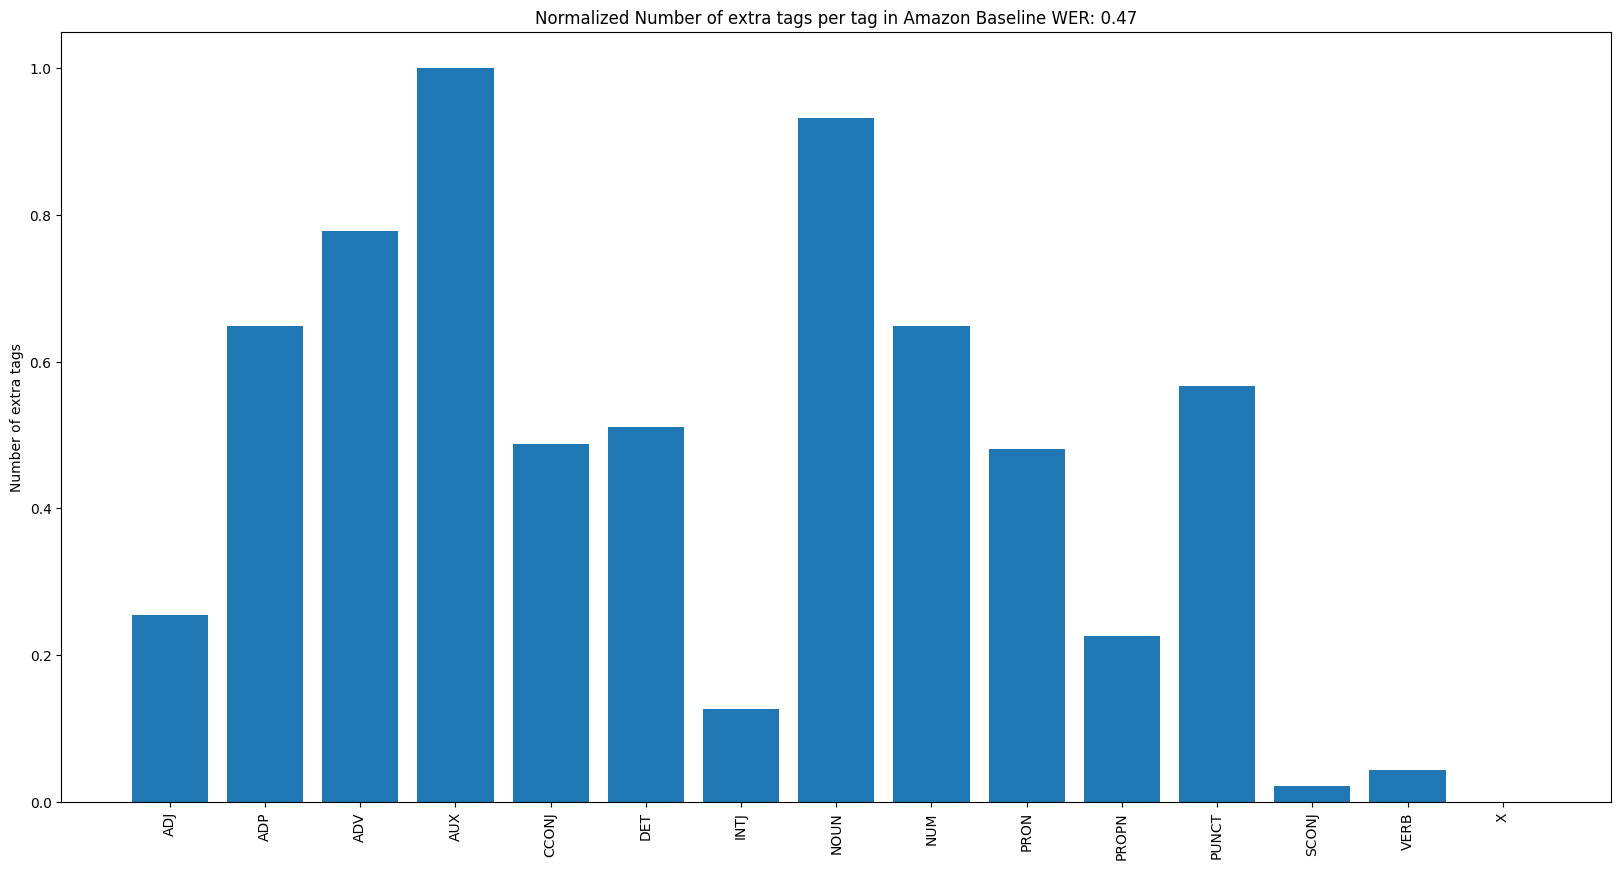

In [99]:
#same for extra tags
data_to_plot = amazon_res_extra
plt.figure(figsize=(20,10))
#normalize y data to be between 0 and 1
normalizer = MinMaxScaler(feature_range=(0, 1))
y_data = list(data_to_plot.values())
y_data = normalizer.fit_transform(np.array(y_data).reshape(-1, 1))  
y_data = [y[0] for y in y_data]
plt.bar(range(len(data_to_plot)), y_data, align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of extra tags")
plt.title(f"Normalized Number of extra tags per tag in Amazon Baseline WER: {round(aws_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
# for i, v in enumerate(data_to_plot.values()):
#     plt.text(i, v, str(v), color='blue', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()
 

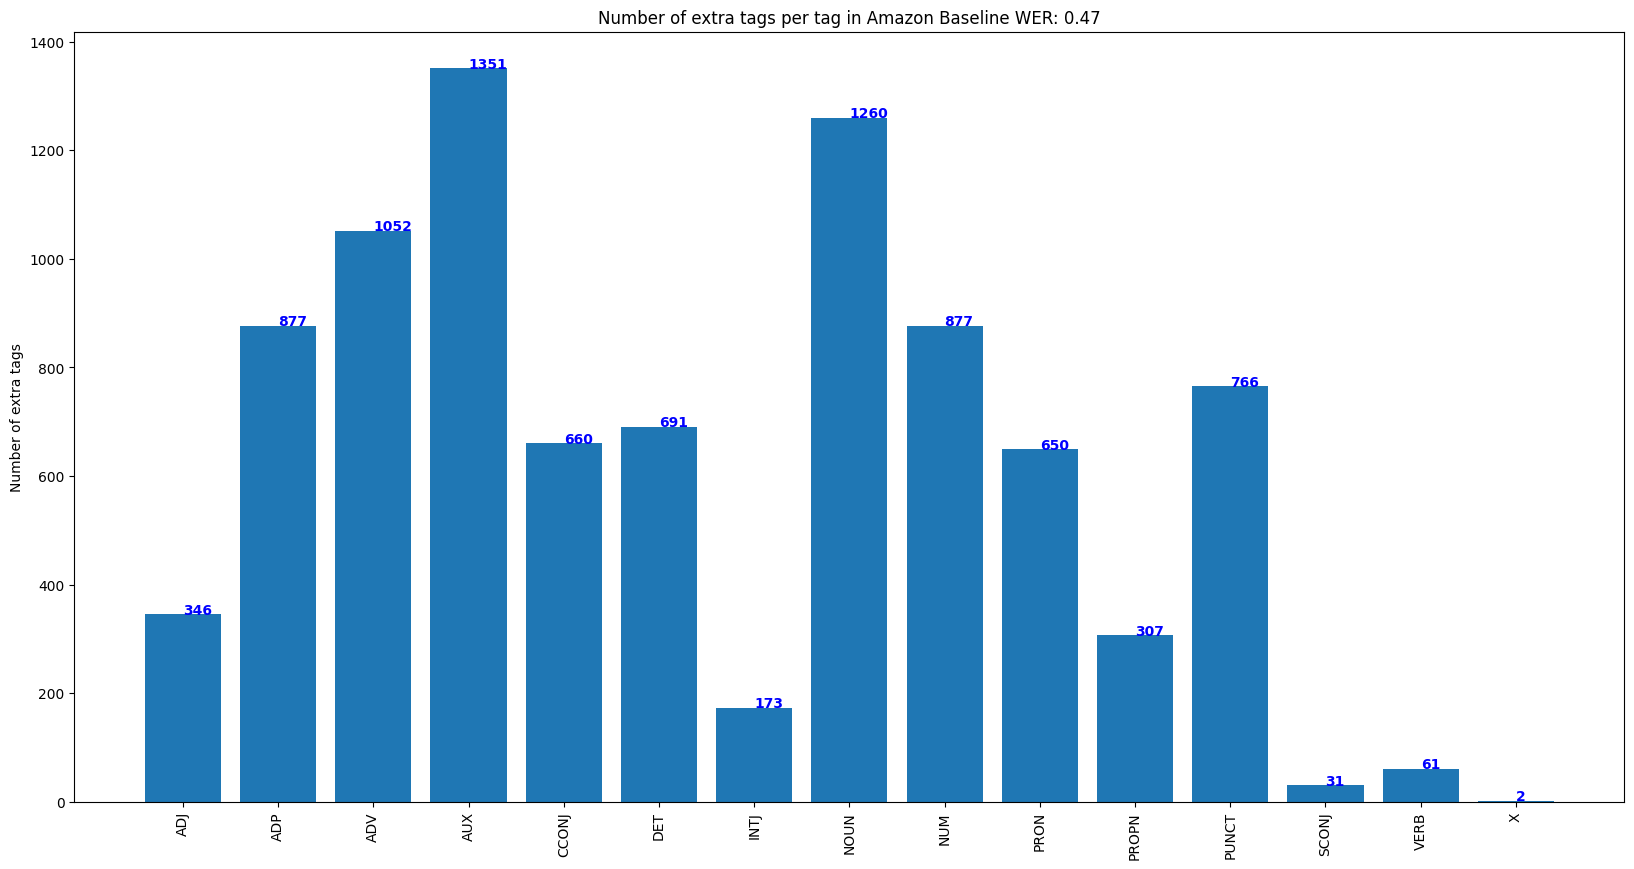

In [100]:
#same for extra tags
data_to_plot = amazon_res_extra
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of extra tags")
plt.title(f"Number of extra tags per tag in Amazon Baseline WER: {round(aws_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()
 

In [ ]:
#same for google
data_to_plot = google_res_missing
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center', color='green')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of missing tags")
plt.title(f"Number of missing tags per tag in Google Baseline WER: {round(google_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()



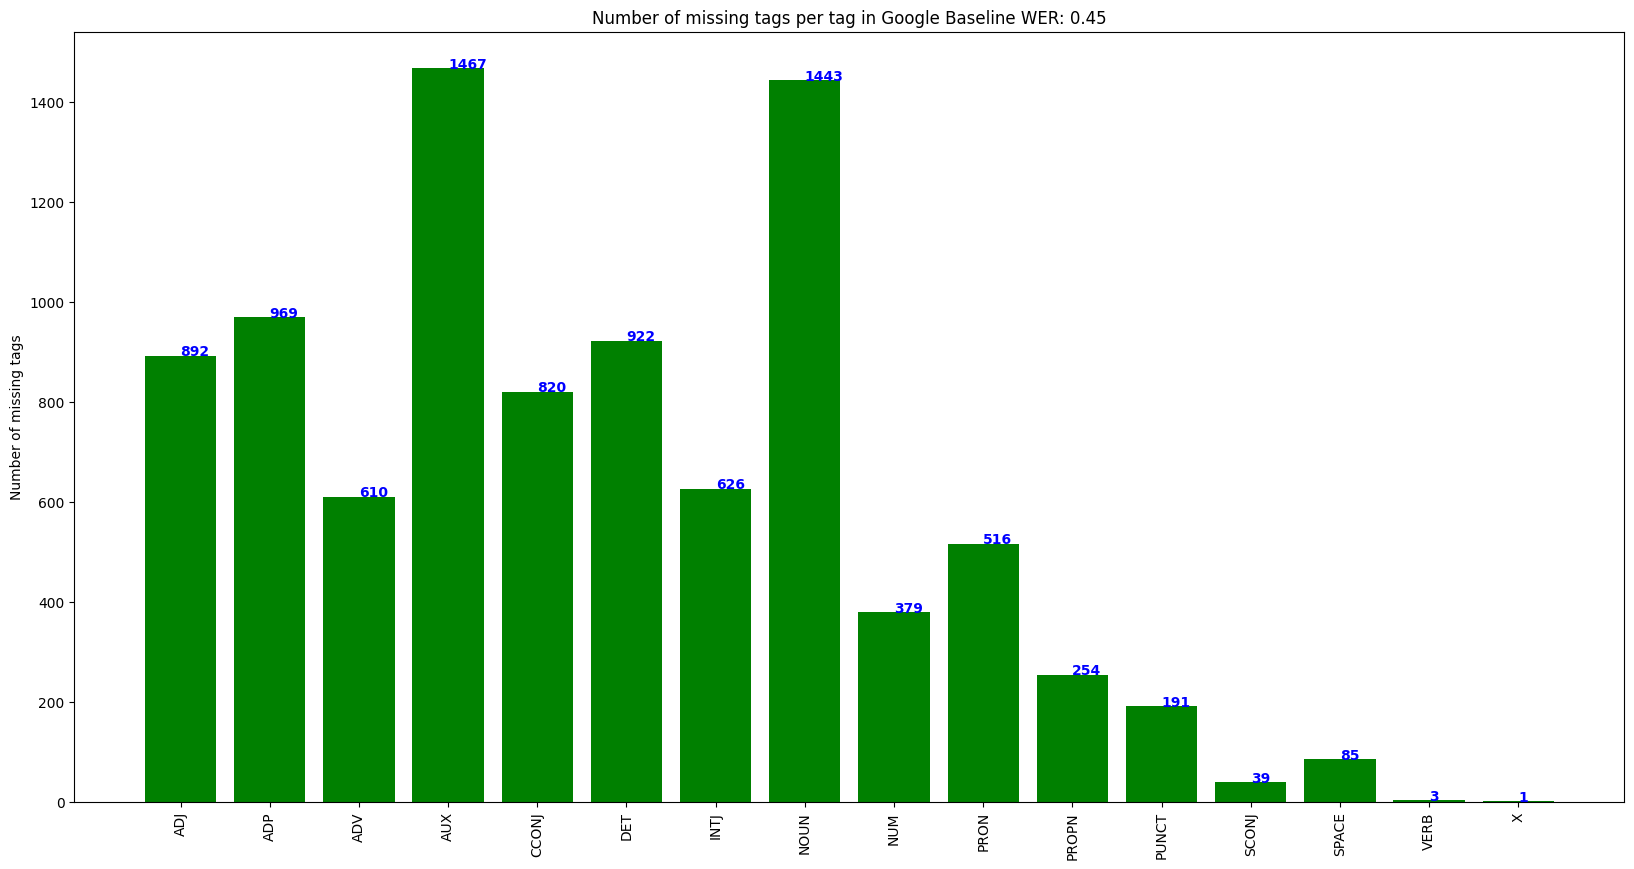

In [56]:
#same for google
data_to_plot = google_res_missing
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center', color='green')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of missing tags")
plt.title(f"Number of missing tags per tag in Google Baseline WER: {round(google_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()



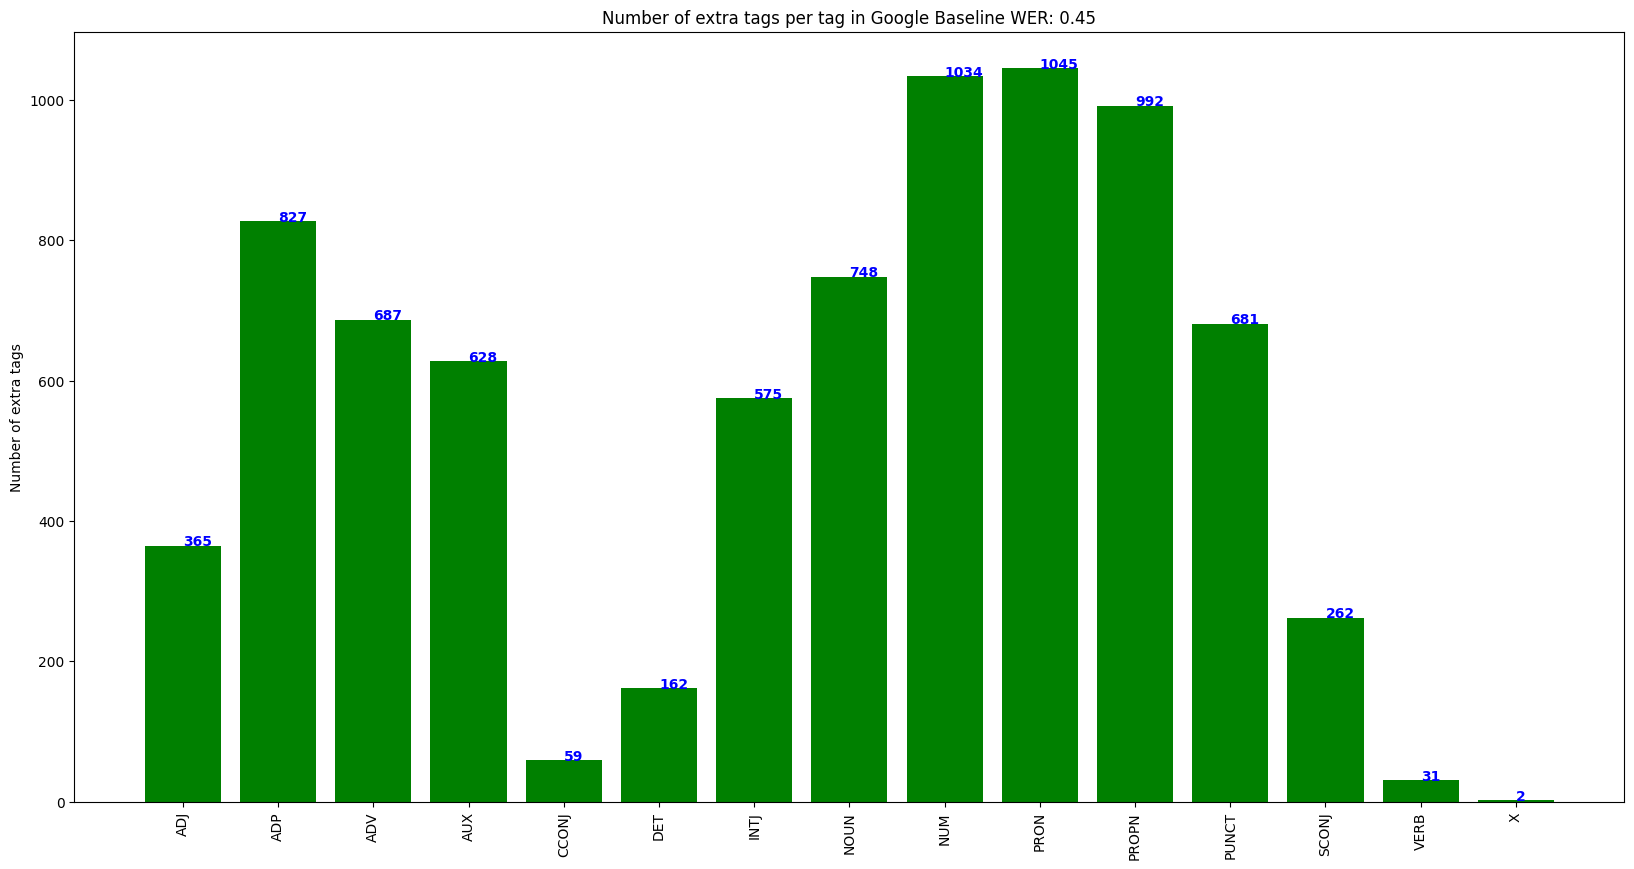

In [57]:
#same for google
data_to_plot = google_res_extra
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center', color='green')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of extra tags")
plt.title(f"Number of extra tags per tag in Google Baseline WER: {round(google_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()



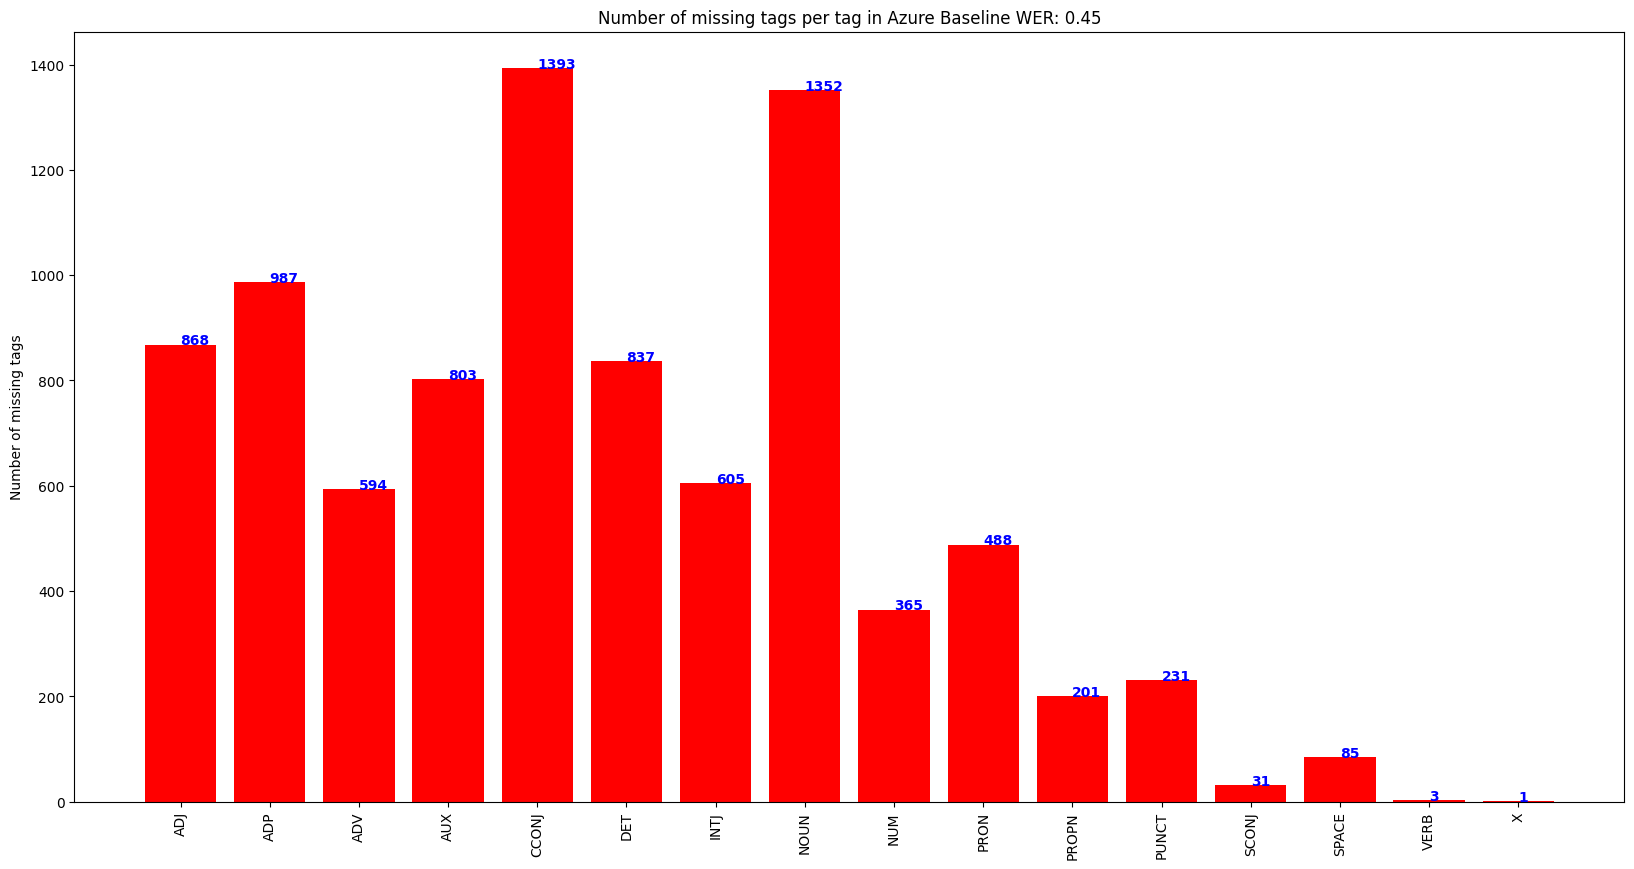

In [58]:
#same for azure
data_to_plot = azure_res_missing
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center', color='red')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of missing tags")
plt.title(f"Number of missing tags per tag in Azure Baseline WER: {round(azure_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()



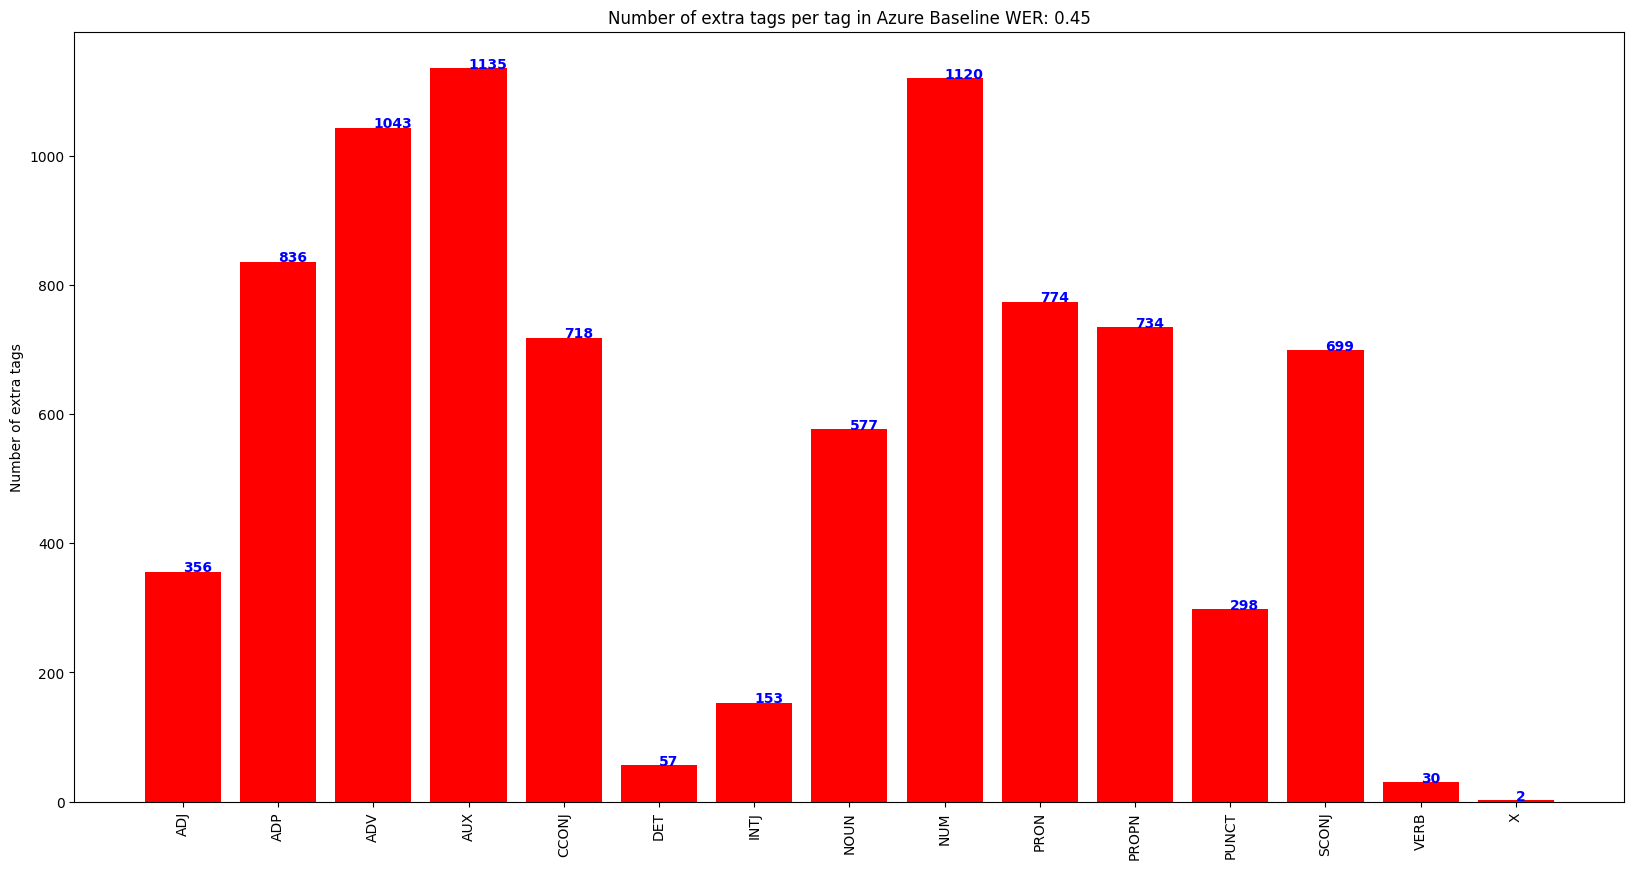

In [59]:
#same for azure
data_to_plot = azure_res_extra
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center',  color='red')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of extra tags")
plt.title(f"Number of extra tags per tag in Azure Baseline WER: {round(azure_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()



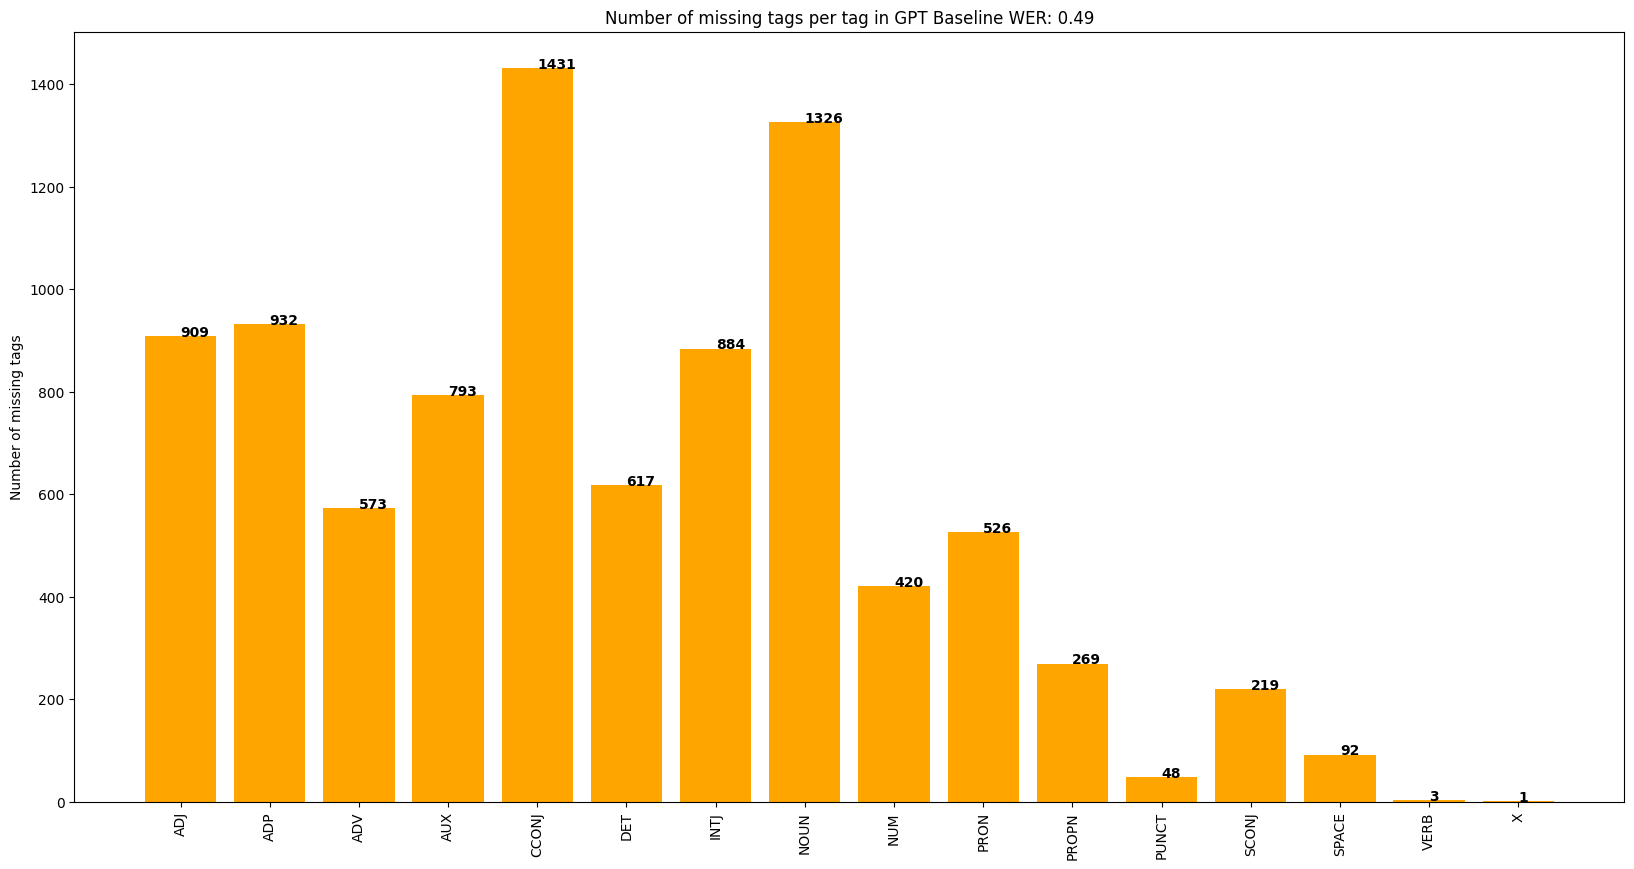

In [60]:
#same for gpt
data_to_plot = gpt_res_missing
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center', color='orange')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of missing tags")
plt.title(f"Number of missing tags per tag in GPT Baseline WER: {round(gpt_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='black', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()

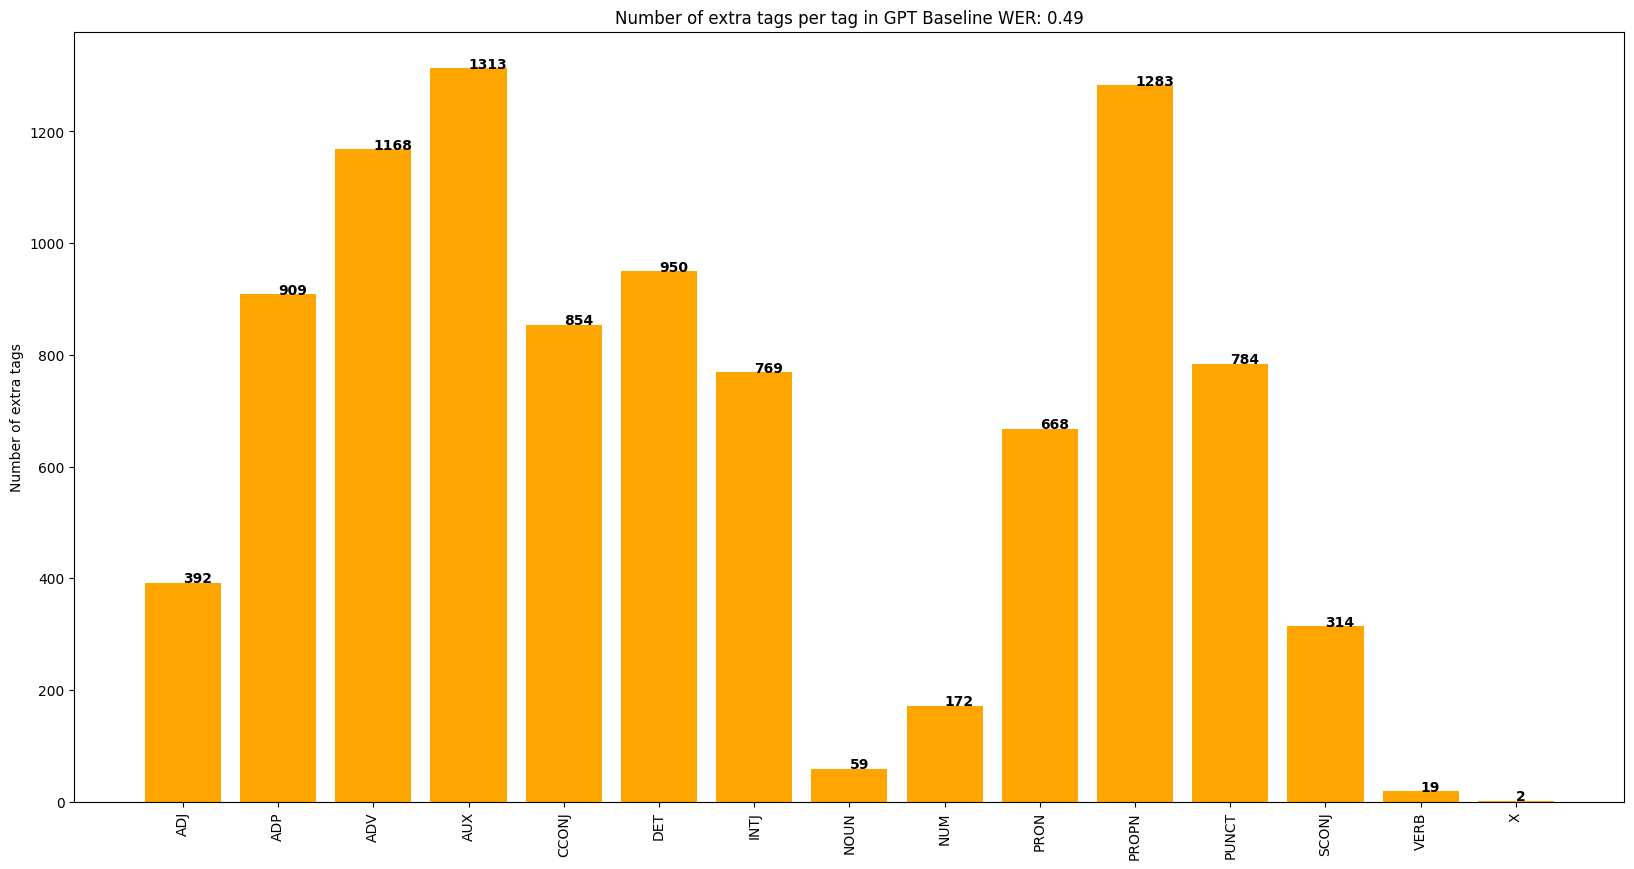

In [61]:
#same for gpt
data_to_plot = gpt_res_extra
plt.figure(figsize=(20,10))
plt.bar(range(len(data_to_plot)), list(data_to_plot.values()), align='center', color='orange')
plt.xticks(range(len(data_to_plot)), list(data_to_plot.keys()), rotation=90)
plt.ylabel("Number of extra tags")
plt.title(f"Number of extra tags per tag in GPT Baseline WER: {round(gpt_wer_scores_v1[0],2)}")
#show the numerical values on the bar chart
for i, v in enumerate(data_to_plot.values()):
    plt.text(i, v, str(v), color='black', fontweight='bold')
plt.gca().set_xticklabels(sorted(data_to_plot.keys()))
plt.show()

In [62]:
from spacy import glossary
tags_to_describe = ["ADJ", "ADP", "ADV", "AUX","CCONJ", "DET", "INTJ", "NOUN", "NUM", "PRON", "PROPN", "PUNCT", "SCONJ","SPACE", "VERB", "X"]
for tag in tags_to_describe:
    print(f"The tag {tag} means: {glossary.explain(tag)}")

The tag ADJ means: adjective
The tag ADP means: adposition
The tag ADV means: adverb
The tag AUX means: auxiliary
The tag CCONJ means: coordinating conjunction
The tag DET means: determiner
The tag INTJ means: interjection
The tag NOUN means: noun
The tag NUM means: numeral
The tag PRON means: pronoun
The tag PROPN means: proper noun
The tag PUNCT means: punctuation
The tag SCONJ means: subordinating conjunction
The tag SPACE means: space
The tag VERB means: verb
The tag X means: other
